# Imports

In [ ]:
import pandas as pd
import re
import nltk
import os

# Download NLTK data if not already present
nltk_data_path = os.path.expanduser('~/nltk_data')
if not os.path.exists(nltk_data_path):
    os.makedirs(nltk_data_path)

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', quiet=True)

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet', quiet=True)

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ikusawalaetitia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ikusawalaetitia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ikusawalaetitia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Strategies

This notebook aims to test several basic models for binary classification. We will start by preprocessing tweets like we did during the EDA (URLs, mentions, hashtags,...), then tokens will be vectorized using either BoW or TF-IDF. Then, we will compare basic machine learning models using MLflow to measure performances of each model and ease the comparison.

**Models to test:**
- Logistic regression - Simple yet effective linear model for binary classification. Works great with bag-of-words or TF-IDF features. Outputs probabilities, which are useful for threshold tuning.
- Random Forest Classifier - Can capture non-linear word interactions without manual feature engineering. Easy to interpret (at least for shallow trees).
- SVM - Very fast and efficient for text (especially with sparse, high-dimensional data). Based on word occurrence probabilities, which often work surprisingly well in text classification. Robust even with relatively small datasets.
- Naive bayes - Very fast and efficient for text (especially with sparse, high-dimensional data). Based on word occurrence probabilities, which often work surprisingly well in text classification. Robust even with relatively small datasets.

**Metrics :**
- Accuracy for an overall performance check
- Precision (positive predicted values / true positives)
- Recall 
- F1-score

# Data and preparation

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', True)

In [ ]:
path = "../data/training.1600000.processed.noemoticon.csv"
# Load the data from the CSV file into a pandas DataFrame
try:
    data = pd.read_csv(path,
                    header=None,
                    names=["target", "ids", "date", "flag", "user", "text"],
                    usecols=["target", "ids", "date", "user", "text"],  # remove flag column
                    parse_dates=["date"],
                    encoding="utf-8",
                    encoding_errors="replace",)
except FileNotFoundError:
    print(f"Error: The file {path} does not exist.")
    raise
except Exception as e:
    print(f"An error occurred while reading the file: {e}")
    raise

# Display the first few rows of the DataFrame and its info
display(data.head())
print(f'Shape of the DataFrame: {data.shape}')

print(f"Number of unique target values: {data['target'].value_counts()}")
# Change target value 4 to 1
data['target'] = data['target'].replace(4, 1)
print(f"Number of unique target values after replacement: {data['target'].value_counts()}")

/var/folders/5n/5_6qtt550_3dxz3f8y6wwjww0000gn/T/ipykernel_95088/4236509596.py:3: FutureWarning: Parsed string "Mon Apr 06 22:19:45 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  data = pd.read_csv(path,


,target,ids,date,user,text
0,0,1467810369,2009-04-06 22:19:45,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all...."


Shape of the DataFrame: (1600000, 5)
Number of unique target values: target
0    800000
4    800000
Name: count, dtype: int64
Number of unique target values after replacement: target
0    800000
1    800000
Name: count, dtype: int64


## Preprocessing

In [3]:
def process_text(text:str, lemmatize:bool=False, stemming:bool=False, advanced_spell_check:bool=False):
    """
    Cleans and preprocesses a single text string by replacing URLs, mentions, and hashtags,
    converting to lowercase, removing special characters, expanding contractions,
    normalizing slang and abbreviations, correcting typos, and removing stopwords.

    Args:
        text (str): The text string to process.
        lemmatize (bool): Whether to lemmatize the tokens.
        stemming (bool): Whether to stem the tokens.
        advanced_spell_check (bool): Whether to use advanced spell checking (requires pyspellchecker).

    Returns:
        str: The processed text string.
    """
    if pd.isna(text):
        return ""

    # Common abbreviations and slang dictionary
    abbrev_dict = {
        # Common abbreviations
        'u': 'you',
        'y': 'why',
        'r': 'are',
        'n': 'and',
        'ur': 'your',
        '2': 'to',
        '4': 'for',
        'b': 'be',
        'c': 'see',
        'idk': 'i do not know',
        'imo': 'in my opinion',
        'tbh': 'to be honest',
        'btw': 'by the way',
        'thx': 'thanks',
        'ty': 'thank you',
        'lol': 'laugh out loud',
        'lmao': 'laughing my ass off',
        'rofl': 'rolling on floor laughing',
        'smh': 'shaking my head',
        'omg': 'oh my god',
        'wtf': 'what the fuck',
        'af': 'as fuck',
        'rn': 'right now',
        'dm': 'direct message',
        'fyi': 'for your information',
        'brb': 'be right back',
        'bff': 'best friend forever',
        'bc': 'because',
        'cuz': 'because',
        'cause': 'because',
        'w/': 'with',
        'w/o': 'without',
        'ppl': 'people',
        'plz': 'please',
        'pls': 'please',
        'srsly': 'seriously',
        'def': 'definitely',
        'prob': 'probably',
        'cmon': 'come on',
        'tmrw': 'tomorrow',
        'tmw': 'tomorrow',
        'yday': 'yesterday',
        'rly': 'really',
        'sth': 'something',
        'sm1': 'someone',
        'grt': 'great',
        'tho': 'though',
        'thru': 'through',
        'msg': 'message',
        'pic': 'picture',
        'pics': 'pictures',
        'irl': 'in real life',
        'probs': 'probably',
        'tho': 'though',
        'tldr': 'too long did not read',

        # Common Twitter slang related to sentiment
        'lit': 'excellent',
        'fire': 'excellent',
        'dope': 'excellent',
        'sick': 'excellent',
        'bomb': 'excellent',
        'killer': 'excellent',
        'wack': 'bad',
        'sus': 'suspicious',
        'salty': 'upset',
        'slay': 'excellent',
        'shook': 'surprised',
        'stan': 'obsessed fan',
        'vibe': 'atmosphere',
        'fam': 'family',
        'lowkey': 'somewhat',
        'highkey': 'very',
        'flex': 'show off',
        'tea': 'gossip',
        'shade': 'disrespect',
        'woke': 'aware',
        'bet': 'alright',
        'legit': 'legitimate',
        'extra': 'excessive',
        'basic': 'mainstream',
        'canceled': 'rejected',
        'ghost': 'ignore',
        'snatched': 'perfect',
        'yeet': 'throw',
        'boujee': 'high class',
        'triggered': 'upset',
        'squad': 'group of friends',
        'goals': 'aspirational',
        'adulting': 'behaving like an adult',
        'rekt': 'wrecked',
        'swag': 'style',
        'yolo': 'you only live once'
    }

    # Negative contractions dictionary (expanded version)
    contractions_dict = {
        "ain't": "am not",
        "aren't": "are not",
        "can't": "cannot",
        "can't've": "cannot have",
        "cause": "because",
        "'cos": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so is",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
    }

    # Function to fix common typos
    def fix_common_typos(text):
        # Common typos and corrections
        typos = {
            'teh': 'the',
            'taht': 'that',
            'adn': 'and',
            'waht': 'what',
            'thnaks': 'thanks',
            'thansk': 'thanks',
            'yuo': 'you',
            'youre': "you're",
            'im': "i'm",
            'hte': 'the',
            'dont': "don't",
            'cant': "can't",
            'wont': "won't",
            'isnt': "isn't",
            'hasnt': "hasn't",
            'wasnt': "wasn't",
            'didnt': "didn't",
            'doesnt': "doesn't",
            'wouldnt': "wouldn't",
            'shouldnt': "shouldn't",
            'couldnt': "couldn't",
            'thats': "that's",
            'whats': "what's"
        }

        words = text.split()
        for i, word in enumerate(words):
            if word in typos:
                words[i] = typos[word]

        return ' '.join(words)

    # Step 1: Fix common typos
    text = fix_common_typos(text)

    # Step 1b: Apply advanced spell checking if requested
    if advanced_spell_check:
        try:
            from spellchecker import SpellChecker
            spell = SpellChecker()

            # Split into words for spell checking
            words = text.split()

            # Find those words that may be misspelled
            for i, word in enumerate(words):
                # Skip URLs, mentions, hashtags and very short words (often abbreviations)
                if ('<' in word or '#' in word or '@' in word or len(word) <= 2 or
                    word.isdigit() or not word.isalpha()):
                    continue

                # Check if the word is misspelled
                if word not in spell:
                    # Get the most likely correction
                    correction = spell.correction(word)
                    if correction and correction != word:
                        words[i] = correction

            text = ' '.join(words)
        except ImportError:
            print("Warning: pyspellchecker not installed. Run 'pip install pyspellchecker' for advanced spell checking.")
            pass

    # Step 2: Replace URLs with <url>
    processed = re.sub(r'https?://\S+', '<url>', text)

    # Step 3: Replace mentions with <mention>
    processed = re.sub(r'@[A-Za-z0-9_]+', '<mention>', processed)

    # Step 4: Separate # from word and replace the word with <hashtag>
    processed = re.sub(r'#([A-Za-z0-9_]+)', r'<hashtag>', processed)

    # Step 5: Convert text to lowercase
    processed = processed.lower()

    # Step 6: Expand contractions
    for contraction, expansion in contractions_dict.items():
        processed = re.sub(r'\b' + contraction + r'\b', expansion, processed)

    # Step 7: Replace common abbreviations and slang
    # First tokenize to ensure we only replace whole words
    words = processed.split()
    for i, word in enumerate(words):
        # Clean the word of any punctuation for matching
        clean_word = re.sub(r'[^\w\s]', '', word)
        if clean_word in abbrev_dict:
            # Replace with the expansion but keep any punctuation
            words[i] = re.sub(r'\b' + clean_word + r'\b', abbrev_dict[clean_word], word)

    processed = ' '.join(words)

    # Step 8: Remove special characters and numbers, keeping !, ?, and ellipsis (...)
    # Also keeps the placeholders <URL>, <MENTION>, <HASHTAG>
    processed = re.sub(r'[^a-z0-9\s.!?<>#]', '', processed)

    # Step 9: Handle repeating characters (common in social media to express emphasis)
    # e.g., "sooooo goooood" -> "so good"
    processed = re.sub(r'(\w)\1{2,}', r'\1\1', processed)  # Keep max 2 repeating chars

    # Step 10: Tokenize the text
    tokens = word_tokenize(processed)

    # Check if both stemming and lemmatization are requested
    if stemming and lemmatize:
        raise ValueError("Cannot use both stemming and lemmatization at the same time. Choose one.")

    # Step 11: Apply lemmatization if requested
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Step 12: Apply stemming if requested
    if stemming:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]

    # Step 13: Define negative words that should not be removed
    negative_words = {
        'no', 'not', 'nor', "don't", "aren't", "couldn't", "didn't", "doesn't",
        "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't",
        "needn't", "shan't", "shouldn't", "wasn't", "weren't", "won't", "wouldn't",
        "never", "none", "nobody", "nothing", "nowhere", "neither", "cannot", "am not",
        "are not", "is not", "do not", "does not", "did not", "has not", "have not",
        "had not", "will not", "would not", "could not", "should not"
    }

    # Step 14: Create a set of stopwords to remove, excluding the negative words
    stop_words_to_remove = set(stopwords.words('english')) - negative_words

    # Step 15: Remove stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words_to_remove]

    # Step 16: Join back to string
    return ' '.join(filtered_tokens)


In [8]:
# Keep text with more then 5 words
selected_df = data[data['text'].apply(lambda x: len(str(x).split()) > 5)].copy()
print(f"Shape of the DataFrame after filtering short texts: {selected_df.shape}")

Shape of the DataFrame after filtering short texts: (50000, 9)


In [9]:
# Sample dataframe for each target
negative_sample = selected_df[selected_df['target'] == 0].sample(n=25000, random_state=42)
positive_sample = selected_df[selected_df['target'] == 1].sample(n=25000, random_state=42)
# Concatenate the two samples
sample_df = pd.concat([negative_sample, positive_sample], ignore_index=True)
# Apply the process_text function to the 'text' column
nltk.download('punkt_tab')
sample_df['processed_text_lem'] = sample_df['text'].apply(process_text, lemmatize=True)
sample_df['advanced_processed_text_lem'] = sample_df['text'].apply(process_text, lemmatize=True, advanced_spell_check=True)
sample_df['processed_text_stem'] = sample_df['text'].apply(process_text, stemming=True)
sample_df['advanced_processed_text_stem'] = sample_df['text'].apply(process_text, stemming=True, advanced_spell_check=True)

# Display the first few rows of the processed DataFrame
display(sample_df.tail())
print(f'Shape of the processed DataFrame: {sample_df.shape}')

# Compare stemming vs lemmatization on a few examples
print("\n\nComparing stemming vs lemmatization on sample tweets:")
comparison_samples = sample_df.sample(5, random_state=42)
for i, row in comparison_samples.iterrows():
    print("\nOriginal text:")
    print(row['text'][:100] + "..." if len(row['text']) > 100 else row['text'])
    print("\nLemmatized:")
    print(row['processed_text_lem'])
    print("\nStemmed:")
    print(row['processed_text_stem'])
    print("-" * 80)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ikusawalaetitia/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


KeyboardInterrupt: 

In [ ]:
# Save the processed DataFrame to a new CSV file
output_path = "../data/processed_sample_tweets.csv"
sample_df.to_csv(output_path, index=False, encoding='utf-8')

## Impact on Sentiment Analysis

These text processing enhancements can significantly improve sentiment analysis accuracy by:

1. **Preserving Negations**: Expanding contractions like "don't", "isn't", "can't" preserves crucial negations that flip sentiment.

2. **Standardizing Language**: Converting slang and abbreviations to standard forms allows the model to better recognize sentiment-carrying phrases.
   - "lit", "fire", "dope" → "excellent" (positive sentiment)
   - "wack", "trash" → "bad" (negative sentiment)

3. **Reducing Dimensionality**: By normalizing typos and variants, we reduce unique tokens, helping the model focus on patterns rather than noise.

4. **Capturing Informal Sentiment**: Social media-specific expressions like "lol" and "smh" carry emotional content that would otherwise be lost.

Remember that this approach works especially well for Twitter data, which contains more informal language than other types of text.

In [7]:
# Test the enhanced process_text function with advanced spell checking

print("Testing advanced spell checking in process_text:")
print("-" * 80)

spell_test_examples = [
    "I absolutly loved thsi movie! The cinematogrphy was awesom.",
    "Teh prodict arrived dmaged and didnt work corectly.",
    "I'm disapointed with teh servic, I woudnt recomend it.",
    "Amazng resturant! The fod was delecius and staf was freindly."
]

for example in spell_test_examples:
    print(f"Original: {example}")
    print(f"Standard processing: {process_text(example)}")
    print(f"With advanced spell checking: {process_text(example, advanced_spell_check=True)}")
    print("-" * 80)

# Compare original dataframe with spell-checked version
print("\nComparing a few tweets with and without advanced spell checking:")
print("-" * 80)

sample_for_spell = sample_df.sample(3, random_state=123)
for i, row in sample_for_spell.iterrows():
    print(f"\nOriginal: {row['text'][:100]}..." if len(row['text']) > 100 else f"\nOriginal: {row['text']}")
    print(f"Standard processing: {process_text(row['text'])[:100]}..." if len(process_text(row['text'])) > 100 else f"Standard processing: {process_text(row['text'])}")
    print(f"With spell checking: {process_text(row['text'], advanced_spell_check=True)[:100]}..." if len(process_text(row['text'], advanced_spell_check=True)) > 100 else f"With spell checking: {process_text(row['text'], advanced_spell_check=True)}")
    print("-" * 80)

Testing advanced spell checking in process_text:
--------------------------------------------------------------------------------
Original: I absolutly loved thsi movie! The cinematogrphy was awesom.
Standard processing: absolutly loved thsi movie ! cinematogrphy awesom .
With advanced spell checking: absolutely loved movie ! cinematography awesom .
--------------------------------------------------------------------------------
Original: Teh prodict arrived dmaged and didnt work corectly.
Standard processing: teh prodict arrived dmaged not work corectly .
With advanced spell checking: product arrived damaged not work corectly .
--------------------------------------------------------------------------------
Original: I'm disapointed with teh servic, I woudnt recomend it.
Standard processing: disapointed servic woudnt recomend .
With advanced spell checking: disappointed servic would not recommend .
--------------------------------------------------------------------------------
Origin

## Benefits of Advanced Spell Checking for Sentiment Analysis

The advanced spell checking capability adds several important benefits for sentiment analysis on Twitter data:

1. **Higher Quality Text Input**: By correcting typos, the model receives cleaner, more standardized text input which helps improve classification accuracy.

2. **Better Feature Recognition**: Common sentiment words that are misspelled (like "amazng" instead of "amazing") will be properly recognized.

3. **Reduced Dimensionality**: Without spell checking, each typo variant becomes its own token in the feature space, diluting the signal of the actual sentiment-carrying words.

4. **Context Preservation**: Unlike simple typo dictionaries, the SpellChecker library considers character proximity on keyboard and common spelling patterns.

5. **Signal Amplification**: Correctly spelling sentiment-carrying words ensures they are properly counted and weighted in the sentiment analysis.

### Implementation Notes:

- The `pyspellchecker` package uses a combination of edit distance algorithms and frequency dictionaries to find the most likely corrections.
- We've made the advanced spell checking optional via the `advanced_spell_check` parameter to allow flexibility in processing.
- We skip spell checking for URLs, mentions, hashtags, and very short words to avoid unnecessary corrections.
- The implementation gracefully handles the case where the spell checker library isn't installed.

This advanced spell checking, combined with our other preprocessing enhancements (slang normalization, contraction expansion, etc.), provides a robust pipeline for handling the noisy, informal text common in social media.

## Split data to train and test sets

In [11]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X_lem = sample_df['processed_text_lem']
y_lem = sample_df['target']

X_stem = sample_df['processed_text_stem']
y_stem = sample_df['target']

# Split the data into training and testing sets
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(
    X_lem, y_lem,
    test_size=0.2,
    random_state=42,
    stratify=y_lem
)

# Display the shapes of the resulting datasets
print(f"X_train_lem shape: {X_train_lem.shape}")
print(f"X_test_lem shape: {X_test_lem.shape}")
print(f"y_train_lem shape: {y_train_lem.shape}")
print(f"y_test_lem shape: {y_test_lem.shape}")

# Split the data into training and testing sets
X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(
    X_stem, y_stem,
    test_size=0.2,
    random_state=42,
    stratify=y_stem
)

# Display the shapes of the resulting datasets
print(f"X_train_stem shape: {X_train_stem.shape}")
print(f"X_test_stem shape: {X_test_stem.shape}")
print(f"y_train_stem shape: {y_train_stem.shape}")
print(f"y_test_stem shape: {y_test_stem.shape}")

X_train_shape = X_train_lem.shape
X_test_shape = X_test_lem.shape

X_train_lem shape: (40000,)
X_test_lem shape: (10000,)
y_train_lem shape: (40000,)
y_test_lem shape: (10000,)
X_train_stem shape: (40000,)
X_test_stem shape: (10000,)
y_train_stem shape: (40000,)
y_test_stem shape: (10000,)


In [12]:
# Split the data for the advanced spell-checked lemmatized text
X_adv_lem = sample_df['advanced_processed_text_lem']
y_adv_lem = sample_df['target']

X_train_adv_lem, X_test_adv_lem, y_train_adv_lem, y_test_adv_lem = train_test_split(
    X_adv_lem, y_adv_lem,
    test_size=0.2,
    random_state=42,
    stratify=y_adv_lem
)
# split the data for the advanced spell-checked stemmed text
X_adv_stem = sample_df['advanced_processed_text_stem']
y_adv_stem = sample_df['target']

X_train_adv_stem, X_test_adv_stem, y_train_adv_stem, y_test_adv_stem = train_test_split(
    X_adv_stem, y_adv_stem,
    test_size=0.2,
    random_state=42,
    stratify=y_adv_stem
)

# Configuring MLflow

In [13]:
import os
from dotenv import load_dotenv
import time
import pickle

import mlflow
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient


from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,fbeta_score, roc_curve, classification_report, make_scorer, matthews_corrcoef, balanced_accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_score

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm


# For scikit-learn
mlflow.sklearn.autolog()

# Configuring MLflow
load_dotenv()
tracking_uri = os.getenv("MLFLOW_TRACKING_URI")
mlflow.set_tracking_uri(tracking_uri)
print(f"MLflow Tracking URI: {tracking_uri}")

MLflow Tracking URI: http://localhost:8081


In [ ]:
# Create a new MLflow Experiment
mlflow.set_experiment("P7-Sentiments_Analysis")

<Experiment: artifact_location='mlflow-artifacts:/936418666609461070', creation_time=1762469617806, experiment_id='936418666609461070', last_update_time=1762469617806, lifecycle_stage='active', name='P7-Sentiments_Analysis', tags={}>

In [16]:
import numpy as np
# Helper function to prepare data for MLflow logging
def prepare_for_mlflow(X):
    """
    Convert pandas Series or DataFrame to a format that's compatible with MLflow logging.

    Args:
        X: Input data (pandas Series, DataFrame or sparse matrix)

    Returns:
        A numpy array or scipy sparse matrix that MLflow can handle
    """
    from scipy import sparse

    if isinstance(X, pd.Series):
        # Convert Series to a 2D numpy array with shape (n_samples, 1)
        return np.array(X).reshape(-1, 1)
    elif isinstance(X, pd.DataFrame):
        # DataFrame is already 2D
        return X.values
    elif sparse.issparse(X):
        # Sparse matrices are fine as-is
        return X
    else:
        # For other types, try to convert to numpy array
        return np.array(X)

## Evaluation function

In [ ]:
def evaluate_model(model, X_test, y_test, model_name, vectorizer_name):
    """
    Evaluates a machine learning model using various metrics and visualizations.
    Args:
        model: The trained machine learning model to evaluate.
        X_test: The test features.
        y_test: The true labels for the test set.
        model_name: The name of the model being evaluated.
        vectorizer_name: The name of the vectorizer used for feature extraction.
    Returns:
        accuracy, precision, recall, f1, f05, f2, roc_auc: Evaluation metrics.
        fig_cm: Figure of the confusion matrix.
        fig_roc: Figure of the ROC curve.
        y_pred: Predicted labels for the test set.
    """
    # Predict the labels for the test set
    y_pred = model.predict(X_test)

    # Get the predicted probabilities or decision function scores
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_score = model.decision_function(X_test)
    else:
        y_score = y_pred  # Fallback for models without probability estimates

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_score)

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax_cm)
    ax_cm.set_xlabel('Prediction')
    ax_cm.set_ylabel('Real label')
    ax_cm.set_title(f'Confusion matrix - {model_name} with {vectorizer_name}')

    # Create the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_score)
    fig_roc, ax_roc = plt.subplots(figsize=(8, 6))
    ax_roc.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax_roc.plot([0, 1], [0, 1], 'k--')
    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.set_title(f'ROC curve - {model_name} with {vectorizer_name}')
    ax_roc.legend(loc="lower right")
    ax_roc.grid(True)

    # Display the results
    print(f"\nResults for {model_name} with {vectorizer_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\nConfusion matrix:")
    print(cm)
    print("\nClassificatin report:")
    print(classification_report(y_test, y_pred))

    return accuracy, precision, recall, specificity, roc_auc, fig_cm, fig_roc, y_pred

## Instantiate the vectorizers

In [18]:
# Instantiate the vectorizers
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
bow_vectorizer = CountVectorizer(max_features=10000, ngram_range=(1, 2))


# Vectorize texts into TF-IDF vectors
X_train_tfidf_lem = tfidf_vectorizer.fit_transform(X_train_lem)
X_test_tfidf_lem = tfidf_vectorizer.transform(X_test_lem)
X_train_tfidf_stem = tfidf_vectorizer.fit_transform(X_train_stem)
X_test_tfidf_stem = tfidf_vectorizer.transform(X_test_stem)
X_train_tfidf_lem_adv = tfidf_vectorizer.fit_transform(X_train_adv_lem)
X_test_tfidf_lem_adv = tfidf_vectorizer.transform(X_test_adv_lem)
X_train_tfidf_stem_adv = tfidf_vectorizer.fit_transform(X_train_adv_stem)
X_test_tfidf_stem_adv = tfidf_vectorizer.transform(X_test_adv_stem)

# Vectorize texts into Bag-of-Words vectors
X_train_bow_lem = bow_vectorizer.fit_transform(X_train_lem)
X_test_bow_lem = bow_vectorizer.transform(X_test_lem)
X_train_bow_stem = bow_vectorizer.fit_transform(X_train_stem)
X_test_bow_stem = bow_vectorizer.transform(X_test_stem)
X_train_bow_lem_adv = bow_vectorizer.fit_transform(X_train_adv_lem)
X_test_bow_lem_adv = bow_vectorizer.transform(X_test_adv_lem)
X_train_bow_stem_adv = bow_vectorizer.fit_transform(X_train_adv_stem)
X_test_bow_stem_adv = bow_vectorizer.transform(X_test_adv_stem)

## Instanciate models

In [36]:
# Instanciate the models
base_models = {
    "Logistic_Regression": LogisticRegression(random_state=42),
    "SVM_Lineaire": LinearSVC(random_state=42),
    "Random_Forest": RandomForestClassifier(random_state=42),
    "Naive_Bayes": MultinomialNB()
}

# Defined hyperparameters
param_grids = {
    "Logistic_Regression": {
        'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
        'max_iter': [1000, 2000],
        'solver': ['liblinear', 'saga', 'newton-cg', 'lbfgs'],
        'penalty': ['l1', 'l2', 'elasticnet', None],
        'class_weight': [None, 'balanced']
    },
    "SVM_Lineaire": {
        'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
        'max_iter': [1000, 2000],
        'dual': [True, False],
        'class_weight': [None, 'balanced'],
        'loss': ['hinge', 'squared_hinge'],
        'tol': [1e-3, 1e-4]
    },
    "Random_Forest": {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None],
        'class_weight': [None, 'balanced', 'balanced_subsample']
    },
    "Naive_Bayes": {
        'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0],
        'fit_prior': [True, False]
    }
}

# Vectorizers
vectorizers = {
    "TF-IDF_lem": (tfidf_vectorizer, X_train_tfidf_lem, X_test_tfidf_lem, y_train_lem, y_test_lem),
    "BoW_lem": (bow_vectorizer, X_train_bow_lem, X_test_bow_lem, y_train_lem, y_test_lem),
    "TF-IDF_stem": (tfidf_vectorizer, X_train_tfidf_stem, X_test_tfidf_stem, y_train_stem, y_test_stem),
    "BoW_stem": (bow_vectorizer, X_train_bow_stem, X_test_bow_stem, y_train_stem, y_test_stem),
    "TF-IDF_lem_adv": (tfidf_vectorizer, X_train_tfidf_lem_adv, X_test_tfidf_lem_adv, y_train_adv_lem, y_test_adv_lem),
    "BoW_lem_adv": (bow_vectorizer, X_train_bow_lem_adv, X_test_bow_lem_adv, y_train_adv_lem, y_test_adv_lem),
    "TF-IDF_stem_adv": (tfidf_vectorizer, X_train_tfidf_stem_adv, X_test_tfidf_stem_adv, y_train_adv_stem, y_test_adv_stem),
    "BoW_stem_adv": (bow_vectorizer, X_train_bow_stem_adv, X_test_bow_stem_adv, y_train_adv_stem, y_test_adv_stem),
}


# Scorers
scorers = {
    'specificity': make_scorer(recall_score, pos_label=0),
    'mcc': make_scorer(matthews_corrcoef),
    'balanced_acc': make_scorer(balanced_accuracy_score)
}

## Training

In [25]:
# Note on model training strategy:
# For each combination of model type and vectorizer, we will:
# 1. Create a fresh model instance for each vectorization method to avoid any state leakage
# 2. Train the model with default parameters to establish a baseline
# 3. Later perform hyperparameter tuning on the best performing models

# Helper function to get a fresh model instance
def get_fresh_model(model_name):
    """Create a new instance of the specified model with default parameters."""
    if model_name == "Logistic_Regression":
        return LogisticRegression(random_state=42)
    elif model_name == "SVM_Lineaire":
        return LinearSVC(random_state=42)
    elif model_name == "Random_Forest":
        return RandomForestClassifier(random_state=42)
    elif model_name == "Naive_Bayes":
        return MultinomialNB()
    else:
        raise ValueError(f"Unknown model name: {model_name}")

In [57]:
train_models = True  # Set to True to train models
if train_models:
    # Total iterations for the progress bar
    total_iterations = len(base_models) * len(vectorizers)
    progress_bar = tqdm(total=total_iterations, desc="Overall Progress")

    results = []

    # Test each model with the two types of vectorization
    all_training_start_time = time.time()
    for model_name in base_models.keys():
        for strategy, (vectorizer, X_train_vec, X_test_vec, y_train_vec, y_test_vec) in vectorizers.items():
            print(f"\n{'='*80}")
            print(f"Starting training for {model_name} with {vectorizer}...")

            # Create a fresh model instance to avoid any state leakage
            model = get_fresh_model(model_name)

            # Start MLflow run
            with mlflow.start_run(run_name=f"Basic_Model_{model_name}_{vectorizer}"):
                # Log parameters
                mlflow.log_param("model_type", model_name)
                mlflow.log_param("vectorizer_type", vectorizer)
                mlflow.log_param("dataset_size", X_train_shape[0] + X_test_shape[0])
                mlflow.log_param("train_size", X_train_shape[0])
                mlflow.log_param("test_size", X_test_shape[0])
                mlflow.log_param("max_features", 10000)
                mlflow.log_param("ngram_range", "(1, 2)")
                mlflow.log_param("strategy", strategy)


                # Initialize the timer
                start_time = time.time()

                # Train the model
                model.fit(X_train_vec, y_train_vec)

                # Training time
                training_time = time.time() - start_time

                # Log the training time
                mlflow.log_metric("training_time", training_time)

                # Evaluate the best model on the test set
                acc, prec, rec, specificity, roc_auc, fig_cm, fig_roc, y_pred = evaluate_model(
                    model, X_test_vec, y_test_vec, model_name, vectorizer
                )

                # Log metrics
                mlflow.log_metric("accuracy", acc)
                mlflow.log_metric("precision", prec)
                mlflow.log_metric("recall", rec)
                mlflow.log_metric("specificity", specificity)
                mlflow.log_metric("roc_auc", roc_auc)

                # Log confusion matrix and ROC curve figures
                mlflow.log_figure(fig_cm, "confusion_matrix.png")
                mlflow.log_figure(fig_roc, "roc_curve.png")
                plt.close(fig_cm)
                plt.close(fig_roc)

                # Log the model
                # Prepare data for MLflow signature
                X_for_signature = prepare_for_mlflow(X_train_vec)
                y_for_signature = y_pred if not isinstance(y_pred, pd.Series) else y_pred.values

                signature = infer_signature(X_for_signature, y_for_signature)
                mlflow.sklearn.log_model(model, "model", signature=signature)

                # Save the model artifacts into a specific directory
                os.makedirs("./content/basic-model", exist_ok=True)

                # Save and log the vectorizer
                vectorizer_path = f"./content/basic-model/vectorizer_{vectorizer}.pkl"
                with open(vectorizer_path, "wb") as f:
                    pickle.dump(vectorizer, f)
                mlflow.log_artifact(vectorizer_path)

                # Save the results in a list
                results.append({
                    "Model": model_name.replace("_", " "),
                    "Vectorization": vectorizer,
                    "Accuracy": acc,
                    "Precision": prec,
                    "Recall": rec,
                    "ROC AUC": roc_auc,
                    "Training time (s)": training_time
                })

                # Display the results
                print(f"Accuracy: {acc:.4f}")
                print(f"Specificity: {specificity:.4f}")
                print(f"ROC AUC test: {roc_auc:.4f}")
                print(f"Training time: {training_time:.2f} secondes")


            # Update the progress bar
            progress_bar.update(1)
            progress_bar.set_description(f"Last model: {model_name} with {vectorizer}")

    progress_bar.close()
    all_training_time = time.time() - all_training_start_time
    # Print total time in minutes
    print(f"\nTotal training time for all models: {all_training_time / 60:.2f} minutes")

Overall Progress:   0%|          | 0/32 [00:00<?, ?it/s]


Starting training for Logistic_Regression with TfidfVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 14:27:59 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/07 14:28:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Logistic_Regression with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7733
Precision: 0.7684
Recall: 0.7824
Specificity: 0.7642
ROC AUC: 0.8498

Confusion matrix:
[[3821 1179]
 [1088 3912]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      5000
           1       0.77      0.78      0.78      5000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



Last model: Logistic_Regression with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):   3%|▎         | 1/32 [00:06<03:19,  6.44s/it]

Accuracy: 0.7733
Specificity: 0.7642
ROC AUC test: 0.8498
Training time: 4.61 secondes
🏃 View run Basic_Model_Logistic_Regression_TfidfVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/facaf1425f9b46e68bad3ff1b475a897
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for Logistic_Regression with CountVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 14:28:05 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/07 14:28:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Logistic_Regression with CountVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7606
Precision: 0.7532
Recall: 0.7752
Specificity: 0.7460
ROC AUC: 0.8345

Confusion matrix:
[[3730 1270]
 [1124 3876]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      5000
           1       0.75      0.78      0.76      5000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



Last model: Logistic_Regression with CountVectorizer(max_features=10000, ngram_range=(1, 2)):   6%|▋         | 2/32 [00:15<04:05,  8.18s/it]

Accuracy: 0.7606
Specificity: 0.7460
ROC AUC test: 0.8345
Training time: 6.97 secondes
🏃 View run Basic_Model_Logistic_Regression_CountVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/731e7542723b4f49954bf21fac527a1f
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for Logistic_Regression with TfidfVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 14:28:15 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/07 14:28:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Logistic_Regression with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7703
Precision: 0.7640
Recall: 0.7822
Specificity: 0.7584
ROC AUC: 0.8516

Confusion matrix:
[[3792 1208]
 [1089 3911]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      5000
           1       0.76      0.78      0.77      5000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



Last model: Logistic_Regression with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):   9%|▉         | 3/32 [00:23<03:53,  8.05s/it]

Accuracy: 0.7703
Specificity: 0.7584
ROC AUC test: 0.8516
Training time: 5.96 secondes
🏃 View run Basic_Model_Logistic_Regression_TfidfVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/c16e32cf26d74699afee6c8c262fe245
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for Logistic_Regression with CountVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 14:28:23 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
/Users/ikusawalaetitia/Documents/oc-projects/python/aiengineer/P7-Sentiments_analysis/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2025/11/07 14:28:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Logistic_Regression with CountVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7610
Precision: 0.7543
Recall: 0.7742
Specificity: 0.7478
ROC AUC: 0.8355

Confusion matrix:
[[3739 1261]
 [1129 3871]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      5000
           1       0.75      0.77      0.76      5000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



Last model: Logistic_Regression with CountVectorizer(max_features=10000, ngram_range=(1, 2)):  12%|█▎        | 4/32 [00:38<05:02, 10.81s/it]

Accuracy: 0.7610
Specificity: 0.7478
ROC AUC test: 0.8355
Training time: 12.87 secondes
🏃 View run Basic_Model_Logistic_Regression_CountVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/276fa1a50992423ab2e25637de322e1c
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for Logistic_Regression with TfidfVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 14:28:39 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/07 14:28:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Logistic_Regression with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7727
Precision: 0.7685
Recall: 0.7806
Specificity: 0.7648
ROC AUC: 0.8500

Confusion matrix:
[[3824 1176]
 [1097 3903]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      5000
           1       0.77      0.78      0.77      5000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



Last model: Logistic_Regression with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):  16%|█▌        | 5/32 [00:50<05:05, 11.30s/it]

Accuracy: 0.7727
Specificity: 0.7648
ROC AUC test: 0.8500
Training time: 10.02 secondes
🏃 View run Basic_Model_Logistic_Regression_TfidfVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/70bcb3dd4f924b57b80d7b468a71663f
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for Logistic_Regression with CountVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 14:28:50 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/07 14:29:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Logistic_Regression with CountVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7589
Precision: 0.7514
Recall: 0.7738
Specificity: 0.7440
ROC AUC: 0.8337

Confusion matrix:
[[3720 1280]
 [1131 3869]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.77      0.74      0.76      5000
           1       0.75      0.77      0.76      5000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



Last model: Logistic_Regression with CountVectorizer(max_features=10000, ngram_range=(1, 2)):  19%|█▉        | 6/32 [01:06<05:29, 12.67s/it]

Accuracy: 0.7589
Specificity: 0.7440
ROC AUC test: 0.8337
Training time: 13.25 secondes
🏃 View run Basic_Model_Logistic_Regression_CountVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/2787277e5e8b4768bf5e14b99e3d35c0
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for Logistic_Regression with TfidfVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 14:29:05 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/07 14:29:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Logistic_Regression with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7713
Precision: 0.7651
Recall: 0.7830
Specificity: 0.7596
ROC AUC: 0.8512

Confusion matrix:
[[3798 1202]
 [1085 3915]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      5000
           1       0.77      0.78      0.77      5000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



Last model: Logistic_Regression with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):  22%|██▏       | 7/32 [01:13<04:31, 10.85s/it]

Accuracy: 0.7713
Specificity: 0.7596
ROC AUC test: 0.8512
Training time: 5.05 secondes
🏃 View run Basic_Model_Logistic_Regression_TfidfVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/7a34ee3e76754996b494e6a575a5d014
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for Logistic_Regression with CountVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 14:29:13 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
/Users/ikusawalaetitia/Documents/oc-projects/python/aiengineer/P7-Sentiments_analysis/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2025/11/07 14:29:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Logistic_Regression with CountVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7614
Precision: 0.7531
Recall: 0.7778
Specificity: 0.7450
ROC AUC: 0.8347

Confusion matrix:
[[3725 1275]
 [1111 3889]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.77      0.74      0.76      5000
           1       0.75      0.78      0.77      5000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



Last model: Logistic_Regression with CountVectorizer(max_features=10000, ngram_range=(1, 2)):  25%|██▌       | 8/32 [01:29<05:01, 12.57s/it]

Accuracy: 0.7614
Specificity: 0.7450
ROC AUC test: 0.8347
Training time: 14.00 secondes
🏃 View run Basic_Model_Logistic_Regression_CountVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/a21ef4d07bbb4dfb959a5daed3ac905e
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for SVM_Lineaire with TfidfVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 14:29:30 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/07 14:29:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for SVM_Lineaire with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7530
Precision: 0.7469
Recall: 0.7654
Specificity: 0.7406
ROC AUC: 0.8319

Confusion matrix:
[[3703 1297]
 [1173 3827]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      5000
           1       0.75      0.77      0.76      5000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



Last model: SVM_Lineaire with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):  28%|██▊       | 9/32 [01:38<04:22, 11.40s/it]       

Accuracy: 0.7530
Specificity: 0.7406
ROC AUC test: 0.8319
Training time: 6.95 secondes
🏃 View run Basic_Model_SVM_Lineaire_TfidfVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/eafd470490ca40288ff8989ff1b51e13
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for SVM_Lineaire with CountVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 14:29:38 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/07 14:29:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for SVM_Lineaire with CountVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7394
Precision: 0.7334
Recall: 0.7522
Specificity: 0.7266
ROC AUC: 0.8055

Confusion matrix:
[[3633 1367]
 [1239 3761]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      5000
           1       0.73      0.75      0.74      5000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



Last model: SVM_Lineaire with CountVectorizer(max_features=10000, ngram_range=(1, 2)):  31%|███▏      | 10/32 [01:52<04:27, 12.18s/it]

Accuracy: 0.7394
Specificity: 0.7266
ROC AUC test: 0.8055
Training time: 11.77 secondes
🏃 View run Basic_Model_SVM_Lineaire_CountVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/559c779c716844d59cf54c37959f2bc7
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for SVM_Lineaire with TfidfVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 14:29:52 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/07 14:29:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for SVM_Lineaire with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7541
Precision: 0.7507
Recall: 0.7608
Specificity: 0.7474
ROC AUC: 0.8334

Confusion matrix:
[[3737 1263]
 [1196 3804]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.76      0.75      0.75      5000
           1       0.75      0.76      0.76      5000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



Last model: SVM_Lineaire with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):  34%|███▍      | 11/32 [02:02<04:05, 11.68s/it]

Accuracy: 0.7541
Specificity: 0.7474
ROC AUC test: 0.8334
Training time: 8.71 secondes
🏃 View run Basic_Model_SVM_Lineaire_TfidfVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/4c3bf2a2b90b45939b1a5811431efe0e
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for SVM_Lineaire with CountVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 14:30:02 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/07 14:30:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for SVM_Lineaire with CountVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7349
Precision: 0.7299
Recall: 0.7458
Specificity: 0.7240
ROC AUC: 0.8042

Confusion matrix:
[[3620 1380]
 [1271 3729]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.74      0.72      0.73      5000
           1       0.73      0.75      0.74      5000

    accuracy                           0.73     10000
   macro avg       0.74      0.73      0.73     10000
weighted avg       0.74      0.73      0.73     10000



Last model: SVM_Lineaire with CountVectorizer(max_features=10000, ngram_range=(1, 2)):  38%|███▊      | 12/32 [02:16<04:05, 12.28s/it]

Accuracy: 0.7349
Specificity: 0.7240
ROC AUC test: 0.8042
Training time: 11.65 secondes
🏃 View run Basic_Model_SVM_Lineaire_CountVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/3f500f72868b4e468f4ef5df15cd1720
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for SVM_Lineaire with TfidfVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 14:30:17 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/07 14:30:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for SVM_Lineaire with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7515
Precision: 0.7470
Recall: 0.7606
Specificity: 0.7424
ROC AUC: 0.8317

Confusion matrix:
[[3712 1288]
 [1197 3803]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      5000
           1       0.75      0.76      0.75      5000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



Last model: SVM_Lineaire with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):  41%|████      | 13/32 [02:26<03:41, 11.68s/it]

Accuracy: 0.7515
Specificity: 0.7424
ROC AUC test: 0.8317
Training time: 8.40 secondes
🏃 View run Basic_Model_SVM_Lineaire_TfidfVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/15bb743a6152413dbb11ab1180241f60
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for SVM_Lineaire with CountVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 14:30:26 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/07 14:30:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for SVM_Lineaire with CountVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7374
Precision: 0.7319
Recall: 0.7492
Specificity: 0.7256
ROC AUC: 0.8037

Confusion matrix:
[[3628 1372]
 [1254 3746]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.74      0.73      0.73      5000
           1       0.73      0.75      0.74      5000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



Last model: SVM_Lineaire with CountVectorizer(max_features=10000, ngram_range=(1, 2)):  44%|████▍     | 14/32 [02:39<03:36, 12.01s/it]

Accuracy: 0.7374
Specificity: 0.7256
ROC AUC test: 0.8037
Training time: 10.78 secondes
🏃 View run Basic_Model_SVM_Lineaire_CountVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/a141513e8789447a82cedf69fdbc76ee
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for SVM_Lineaire with TfidfVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 14:30:39 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/07 14:30:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for SVM_Lineaire with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7540
Precision: 0.7496
Recall: 0.7628
Specificity: 0.7452
ROC AUC: 0.8326

Confusion matrix:
[[3726 1274]
 [1186 3814]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.76      0.75      0.75      5000
           1       0.75      0.76      0.76      5000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



Last model: SVM_Lineaire with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):  47%|████▋     | 15/32 [02:47<03:02, 10.71s/it]

Accuracy: 0.7540
Specificity: 0.7452
ROC AUC test: 0.8326
Training time: 5.93 secondes
🏃 View run Basic_Model_SVM_Lineaire_TfidfVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/3989c19c97bd4baebe550a6a0ad3c292
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for SVM_Lineaire with CountVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 14:30:46 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/07 14:30:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for SVM_Lineaire with CountVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7342
Precision: 0.7276
Recall: 0.7488
Specificity: 0.7196
ROC AUC: 0.8029

Confusion matrix:
[[3598 1402]
 [1256 3744]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.74      0.72      0.73      5000
           1       0.73      0.75      0.74      5000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



Last model: SVM_Lineaire with CountVectorizer(max_features=10000, ngram_range=(1, 2)):  50%|█████     | 16/32 [02:58<02:52, 10.77s/it]

Accuracy: 0.7342
Specificity: 0.7196
ROC AUC test: 0.8029
Training time: 8.95 secondes
🏃 View run Basic_Model_SVM_Lineaire_CountVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/0b3eaadfe0be4a0d89079fc2b5a622a8
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for Random_Forest with TfidfVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 14:30:59 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/07 14:35:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 123dcd759f104a09bb60ea0e0f63cf04. Failed operations: [MlflowException("API request to http://localhost:8081/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=8081): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]
2025/11/07 14:35:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Random_Forest with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7517
Precision: 0.7545
Recall: 0.7462
Specificity: 0.7572
ROC AUC: 0.8278

Confusion matrix:
[[3786 1214]
 [1269 3731]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.75      0.76      0.75      5000
           1       0.75      0.75      0.75      5000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



Last model: Random_Forest with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):  53%|█████▎    | 17/32 [07:28<22:12, 88.86s/it]

Accuracy: 0.7517
Specificity: 0.7572
ROC AUC test: 0.8278
Training time: 250.35 secondes
🏃 View run Basic_Model_Random_Forest_TfidfVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/123dcd759f104a09bb60ea0e0f63cf04
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for Random_Forest with CountVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 14:35:28 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/07 14:39:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 68e6c13de63d47eca28bb65e6ff7a609. Failed operations: [MlflowException("API request to http://localhost:8081/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=8081): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]
2025/11/07 14:39:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Random_Forest with CountVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7527
Precision: 0.7639
Recall: 0.7314
Specificity: 0.7740
ROC AUC: 0.8267

Confusion matrix:
[[3870 1130]
 [1343 3657]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.76      5000
           1       0.76      0.73      0.75      5000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



Last model: Random_Forest with CountVectorizer(max_features=10000, ngram_range=(1, 2)):  56%|█████▋    | 18/32 [12:04<33:49, 144.98s/it]

Accuracy: 0.7527
Specificity: 0.7740
ROC AUC test: 0.8267
Training time: 249.20 secondes
🏃 View run Basic_Model_Random_Forest_CountVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/68e6c13de63d47eca28bb65e6ff7a609
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for Random_Forest with TfidfVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 14:40:04 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/07 14:44:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID fdc1ac46031e4ae79809aecd394ca56c. Failed operations: [MlflowException("API request to http://localhost:8081/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=8081): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]
2025/11/07 14:44:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Random_Forest with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7526
Precision: 0.7552
Recall: 0.7476
Specificity: 0.7576
ROC AUC: 0.8300

Confusion matrix:
[[3788 1212]
 [1262 3738]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.75      0.76      0.75      5000
           1       0.76      0.75      0.75      5000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



Last model: Random_Forest with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):  59%|█████▉    | 19/32 [16:31<39:20, 181.56s/it]

Accuracy: 0.7526
Specificity: 0.7576
ROC AUC test: 0.8300
Training time: 248.13 secondes
🏃 View run Basic_Model_Random_Forest_TfidfVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/fdc1ac46031e4ae79809aecd394ca56c
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for Random_Forest with CountVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 14:44:31 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/07 14:48:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID ad62143faf1148458aff309f96c69540. Failed operations: [MlflowException("API request to http://localhost:8081/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=8081): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]
2025/11/07 14:48:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Random_Forest with CountVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7557
Precision: 0.7656
Recall: 0.7370
Specificity: 0.7744
ROC AUC: 0.8309

Confusion matrix:
[[3872 1128]
 [1315 3685]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      5000
           1       0.77      0.74      0.75      5000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



Last model: Random_Forest with CountVectorizer(max_features=10000, ngram_range=(1, 2)):  62%|██████▎   | 20/32 [21:04<41:48, 209.02s/it]

Accuracy: 0.7557
Specificity: 0.7744
ROC AUC test: 0.8309
Training time: 247.31 secondes
🏃 View run Basic_Model_Random_Forest_CountVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/ad62143faf1148458aff309f96c69540
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for Random_Forest with TfidfVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 14:49:04 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/07 14:53:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID ac8435271f324019a5152eb3f83a15fd. Failed operations: [MlflowException("API request to http://localhost:8081/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=8081): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]
2025/11/07 14:53:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Random_Forest with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7546
Precision: 0.7603
Recall: 0.7436
Specificity: 0.7656
ROC AUC: 0.8303

Confusion matrix:
[[3828 1172]
 [1282 3718]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      5000
           1       0.76      0.74      0.75      5000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



Last model: Random_Forest with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):  66%|██████▌   | 21/32 [25:32<41:34, 226.80s/it]

Accuracy: 0.7546
Specificity: 0.7656
ROC AUC test: 0.8303
Training time: 248.95 secondes
🏃 View run Basic_Model_Random_Forest_TfidfVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/ac8435271f324019a5152eb3f83a15fd
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for Random_Forest with CountVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 14:53:32 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/07 14:57:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d468c350db5b4769907e30396877ff87. Failed operations: [MlflowException("API request to http://localhost:8081/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=8081): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]
2025/11/07 14:57:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Random_Forest with CountVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7474
Precision: 0.7543
Recall: 0.7338
Specificity: 0.7610
ROC AUC: 0.8259

Confusion matrix:
[[3805 1195]
 [1331 3669]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.74      0.76      0.75      5000
           1       0.75      0.73      0.74      5000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



Last model: Random_Forest with CountVectorizer(max_features=10000, ngram_range=(1, 2)):  69%|██████▉   | 22/32 [30:05<40:08, 240.84s/it]

Accuracy: 0.7474
Specificity: 0.7610
ROC AUC test: 0.8259
Training time: 248.20 secondes
🏃 View run Basic_Model_Random_Forest_CountVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/d468c350db5b4769907e30396877ff87
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for Random_Forest with TfidfVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 14:58:05 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/07 15:02:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 3ea217c5d9a843d6abbc7d0594ba44ac. Failed operations: [MlflowException("API request to http://localhost:8081/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=8081): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]
2025/11/07 15:02:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Random_Forest with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7562
Precision: 0.7643
Recall: 0.7408
Specificity: 0.7716
ROC AUC: 0.8328

Confusion matrix:
[[3858 1142]
 [1296 3704]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      5000
           1       0.76      0.74      0.75      5000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



Last model: Random_Forest with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):  72%|███████▏  | 23/32 [34:32<37:17, 248.56s/it]

Accuracy: 0.7562
Specificity: 0.7716
ROC AUC test: 0.8328
Training time: 248.21 secondes
🏃 View run Basic_Model_Random_Forest_TfidfVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/3ea217c5d9a843d6abbc7d0594ba44ac
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for Random_Forest with CountVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 15:02:32 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/07 15:06:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID e2b07c6689364073924d34b16370cf81. Failed operations: [MlflowException("API request to http://localhost:8081/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=8081): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]
2025/11/07 15:06:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Random_Forest with CountVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7507
Precision: 0.7661
Recall: 0.7218
Specificity: 0.7796
ROC AUC: 0.8303

Confusion matrix:
[[3898 1102]
 [1391 3609]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76      5000
           1       0.77      0.72      0.74      5000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



Last model: Random_Forest with CountVectorizer(max_features=10000, ngram_range=(1, 2)):  75%|███████▌  | 24/32 [39:08<34:13, 256.70s/it]

Accuracy: 0.7507
Specificity: 0.7796
ROC AUC test: 0.8303
Training time: 249.95 secondes
🏃 View run Basic_Model_Random_Forest_CountVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/e2b07c6689364073924d34b16370cf81
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for Naive_Bayes with TfidfVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 15:07:07 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/07 15:07:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Naive_Bayes with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7581
Precision: 0.7618
Recall: 0.7510
Specificity: 0.7652
ROC AUC: 0.8352

Confusion matrix:
[[3826 1174]
 [1245 3755]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      5000
           1       0.76      0.75      0.76      5000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



Last model: Naive_Bayes with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):  78%|███████▊  | 25/32 [39:14<21:09, 181.42s/it]  

Accuracy: 0.7581
Specificity: 0.7652
ROC AUC test: 0.8352
Training time: 4.20 secondes
🏃 View run Basic_Model_Naive_Bayes_TfidfVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/3736d7a79d114c45b8042664448872cd
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for Naive_Bayes with CountVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 15:07:12 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/07 15:07:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Naive_Bayes with CountVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7583
Precision: 0.7599
Recall: 0.7552
Specificity: 0.7614
ROC AUC: 0.8318

Confusion matrix:
[[3807 1193]
 [1224 3776]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      5000
           1       0.76      0.76      0.76      5000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



Last model: Naive_Bayes with CountVectorizer(max_features=10000, ngram_range=(1, 2)):  81%|████████▏ | 26/32 [39:20<12:53, 128.83s/it]

Accuracy: 0.7583
Specificity: 0.7614
ROC AUC test: 0.8318
Training time: 4.21 secondes
🏃 View run Basic_Model_Naive_Bayes_CountVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/121124d375814e658382e7491b7da5f3
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for Naive_Bayes with TfidfVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 15:07:19 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/07 15:07:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Naive_Bayes with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7540
Precision: 0.7565
Recall: 0.7492
Specificity: 0.7588
ROC AUC: 0.8356

Confusion matrix:
[[3794 1206]
 [1254 3746]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.75      0.76      0.76      5000
           1       0.76      0.75      0.75      5000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



Last model: Naive_Bayes with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):  84%|████████▍ | 27/32 [39:26<07:40, 92.12s/it] 

Accuracy: 0.7540
Specificity: 0.7588
ROC AUC test: 0.8356
Training time: 4.57 secondes
🏃 View run Basic_Model_Naive_Bayes_TfidfVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/5a846990da2844019115a3c6cc75d06f
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for Naive_Bayes with CountVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 15:07:26 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/07 15:07:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Naive_Bayes with CountVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7578
Precision: 0.7595
Recall: 0.7546
Specificity: 0.7610
ROC AUC: 0.8314

Confusion matrix:
[[3805 1195]
 [1227 3773]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      5000
           1       0.76      0.75      0.76      5000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



Last model: Naive_Bayes with CountVectorizer(max_features=10000, ngram_range=(1, 2)):  88%|████████▊ | 28/32 [39:33<04:25, 66.47s/it]

Accuracy: 0.7578
Specificity: 0.7610
ROC AUC test: 0.8314
Training time: 4.74 secondes
🏃 View run Basic_Model_Naive_Bayes_CountVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/182f1e31a8a24a5ebe4a89793de373e1
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for Naive_Bayes with TfidfVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 15:07:32 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/07 15:07:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Naive_Bayes with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7554
Precision: 0.7607
Recall: 0.7452
Specificity: 0.7656
ROC AUC: 0.8345

Confusion matrix:
[[3828 1172]
 [1274 3726]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      5000
           1       0.76      0.75      0.75      5000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



Last model: Naive_Bayes with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):  91%|█████████ | 29/32 [39:40<02:26, 48.69s/it]

Accuracy: 0.7554
Specificity: 0.7656
ROC AUC test: 0.8345
Training time: 4.65 secondes
🏃 View run Basic_Model_Naive_Bayes_TfidfVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/e33853839d7842b39b1a2eeff29bb3f3
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for Naive_Bayes with CountVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 15:07:40 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/07 15:07:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Naive_Bayes with CountVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7569
Precision: 0.7590
Recall: 0.7528
Specificity: 0.7610
ROC AUC: 0.8310

Confusion matrix:
[[3805 1195]
 [1236 3764]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.75      0.76      0.76      5000
           1       0.76      0.75      0.76      5000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



Last model: Naive_Bayes with CountVectorizer(max_features=10000, ngram_range=(1, 2)):  94%|█████████▍| 30/32 [39:47<01:12, 36.08s/it]

Accuracy: 0.7569
Specificity: 0.7610
ROC AUC test: 0.8310
Training time: 4.71 secondes
🏃 View run Basic_Model_Naive_Bayes_CountVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/604ae36b30d94d37a445cfc81852b32d
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for Naive_Bayes with TfidfVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 15:07:46 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'



Results for Naive_Bayes with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7549
Precision: 0.7580
Recall: 0.7488
Specificity: 0.7610
ROC AUC: 0.8341

Confusion matrix:
[[3805 1195]
 [1256 3744]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.75      0.76      0.76      5000
           1       0.76      0.75      0.75      5000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



2025/11/07 15:07:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Last model: Naive_Bayes with TfidfVectorizer(max_features=10000, ngram_range=(1, 2)):  97%|█████████▋| 31/32 [39:53<00:27, 27.21s/it]

Accuracy: 0.7549
Specificity: 0.7610
ROC AUC test: 0.8341
Training time: 4.39 secondes
🏃 View run Basic_Model_Naive_Bayes_TfidfVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/a988cccbf9a14685b4b9995348f43cef
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Starting training for Naive_Bayes with CountVectorizer(max_features=10000, ngram_range=(1, 2))...


2025/11/07 15:07:53 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/07 15:07:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Naive_Bayes with CountVectorizer(max_features=10000, ngram_range=(1, 2)):
Accuracy: 0.7572
Precision: 0.7585
Recall: 0.7546
Specificity: 0.7598
ROC AUC: 0.8304

Confusion matrix:
[[3799 1201]
 [1227 3773]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      5000
           1       0.76      0.75      0.76      5000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



Last model: Naive_Bayes with CountVectorizer(max_features=10000, ngram_range=(1, 2)): 100%|██████████| 32/32 [40:00<00:00, 75.02s/it]

Accuracy: 0.7572
Specificity: 0.7598
ROC AUC test: 0.8304
Training time: 4.99 secondes
🏃 View run Basic_Model_Naive_Bayes_CountVectorizer(max_features=10000, ngram_range=(1, 2)) at: http://localhost:8081/#/experiments/936418666609461070/runs/0c5d39b76b5c4addbe87a82cb16cc281
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070

Total training time for all models: 40.01 minutes


## Evaluation

In [58]:
# Override get_mlflow_results to keep only the best run per (model, vectorization)
def get_mlflow_results(experiment_name:str ="P7-Sentiments_Analysis", run_name: str = "Basic_Model", uri: str = None):
    """
    Retrieve MLflow runs and retain the best (and most recent on ties) per model/vectorizer pair.
    """
    if uri:
        mlflow.set_tracking_uri(uri)

    client = MlflowClient()

    try:
        experiment = client.get_experiment_by_name(experiment_name)
        if not experiment:
            raise ValueError(f"Experiment '{experiment_name}' not found.")
        experiment_id = experiment.experiment_id
    except Exception as e:
        print(f"Error retrieving experiment '{experiment_name}': {experiment}")
        return pd.DataFrame()

    runs = client.search_runs(
        experiment_ids=[experiment_id],
        filter_string=f"tags.mlflow.runName LIKE '%{run_name}%'",
        order_by=["metrics.specificity DESC"],
    )

    results = []
    for run in runs:
        run_name = run.data.tags.get("mlflow.runName", "")
        model_type = run.data.params.get("model_type", "").replace("_", " ")
        vectorization_type = run.data.params.get("vectorizer_type", "")
        metrics = run.data.metrics

        results.append({
            "Run Name": run_name,
            "Run ID": run.info.run_id,
            "Strategy": strategy,
            "Model": model_type,
            "Vectorization": vectorization_type,
            "Accuracy": metrics.get("accuracy"),
            "Precision": metrics.get("precision"),
            "Recall": metrics.get("recall"),
            "Specificity": metrics.get("specificity"),
            "ROC AUC": metrics.get("roc_auc"),
            "Training Time (s)": metrics.get("training_time"),
            "Run Start (UTC)": pd.to_datetime(run.info.start_time, unit="ms") if run.info.start_time else None,
        })

    results_df = pd.DataFrame(results)
    if results_df.empty:
        return results_df

    numeric_cols = [
        "Accuracy",
        "Precision",
        "Recall",
        "Specificity",
        "ROC AUC",
        "Training Time (s)",
    ]
    for col in numeric_cols:
        if col in results_df.columns:
            results_df[col] = pd.to_numeric(results_df[col], errors="coerce")

    sort_columns = ["Specificity", "Accuracy", "Run Start (UTC)"]
    ascending = [False, False, False]
    results_df = results_df.sort_values(by=sort_columns, ascending=ascending)
    results_df = results_df.drop_duplicates(subset=["Model", "Vectorization"], keep="first")
    results_df.reset_index(drop=True, inplace=True)

    return results_df


In [59]:
results_df = get_mlflow_results(experiment_name="P7-Sentiments_Analysis", run_name="Basic_Model_", uri=tracking_uri)

In [60]:
display(results_df)

,Run Name,Run ID,Strategy,Model,Vectorization,Accuracy,Precision,Recall,Specificity,ROC AUC,Training Time (s),Run Start (UTC)
0,Basic_Model_Random_Forest_CountVectorizer(max_...,e2b07c6689364073924d34b16370cf81,BoW_stem_adv,Random Forest,"CountVectorizer(max_features=10000, ngram_rang...",0.7507,0.766079,0.7218,0.7796,0.830335,249.954655,2025-11-07 14:02:30.563
1,Basic_Model_Random_Forest_TfidfVectorizer(max_...,3ea217c5d9a843d6abbc7d0594ba44ac,BoW_stem_adv,Random Forest,"TfidfVectorizer(max_features=10000, ngram_rang...",0.7562,0.764342,0.7408,0.7716,0.832778,248.208255,2025-11-07 13:58:03.998
2,Basic_Model_Naive_Bayes_TfidfVectorizer(max_fe...,e33853839d7842b39b1a2eeff29bb3f3,BoW_stem_adv,Naive Bayes,"TfidfVectorizer(max_features=10000, ngram_rang...",0.7554,0.760719,0.7452,0.7656,0.834528,4.647662,2025-11-07 14:07:31.277
3,Basic_Model_Logistic_Regression_TfidfVectorize...,70bcb3dd4f924b57b80d7b468a71663f,BoW_stem_adv,Logistic Regression,"TfidfVectorizer(max_features=10000, ngram_rang...",0.7727,0.768458,0.7806,0.7648,0.849955,10.020120,2025-11-07 13:28:36.795
4,Basic_Model_Naive_Bayes_CountVectorizer(max_fe...,121124d375814e658382e7491b7da5f3,BoW_stem_adv,Naive Bayes,"CountVectorizer(max_features=10000, ngram_rang...",0.7583,0.759911,0.7552,0.7614,0.831753,4.214680,2025-11-07 14:07:12.052
5,Basic_Model_Logistic_Regression_CountVectorize...,276fa1a50992423ab2e25637de322e1c,BoW_stem_adv,Logistic Regression,"CountVectorizer(max_features=10000, ngram_rang...",0.7610,0.754287,0.7742,0.7478,0.835523,12.871461,2025-11-07 13:28:21.760
6,Basic_Model_SVM_Lineaire_TfidfVectorizer(max_f...,4c3bf2a2b90b45939b1a5811431efe0e,BoW_stem_adv,SVM Lineaire,"TfidfVectorizer(max_features=10000, ngram_rang...",0.7541,0.750740,0.7608,0.7474,0.833437,8.706783,2025-11-07 13:29:50.411
7,Basic_Model_SVM_Lineaire_CountVectorizer(max_f...,559c779c716844d59cf54c37959f2bc7,BoW_stem_adv,SVM Lineaire,"CountVectorizer(max_features=10000, ngram_rang...",0.7394,0.733424,0.7522,0.7266,0.805505,11.772023,2025-11-07 13:29:36.475


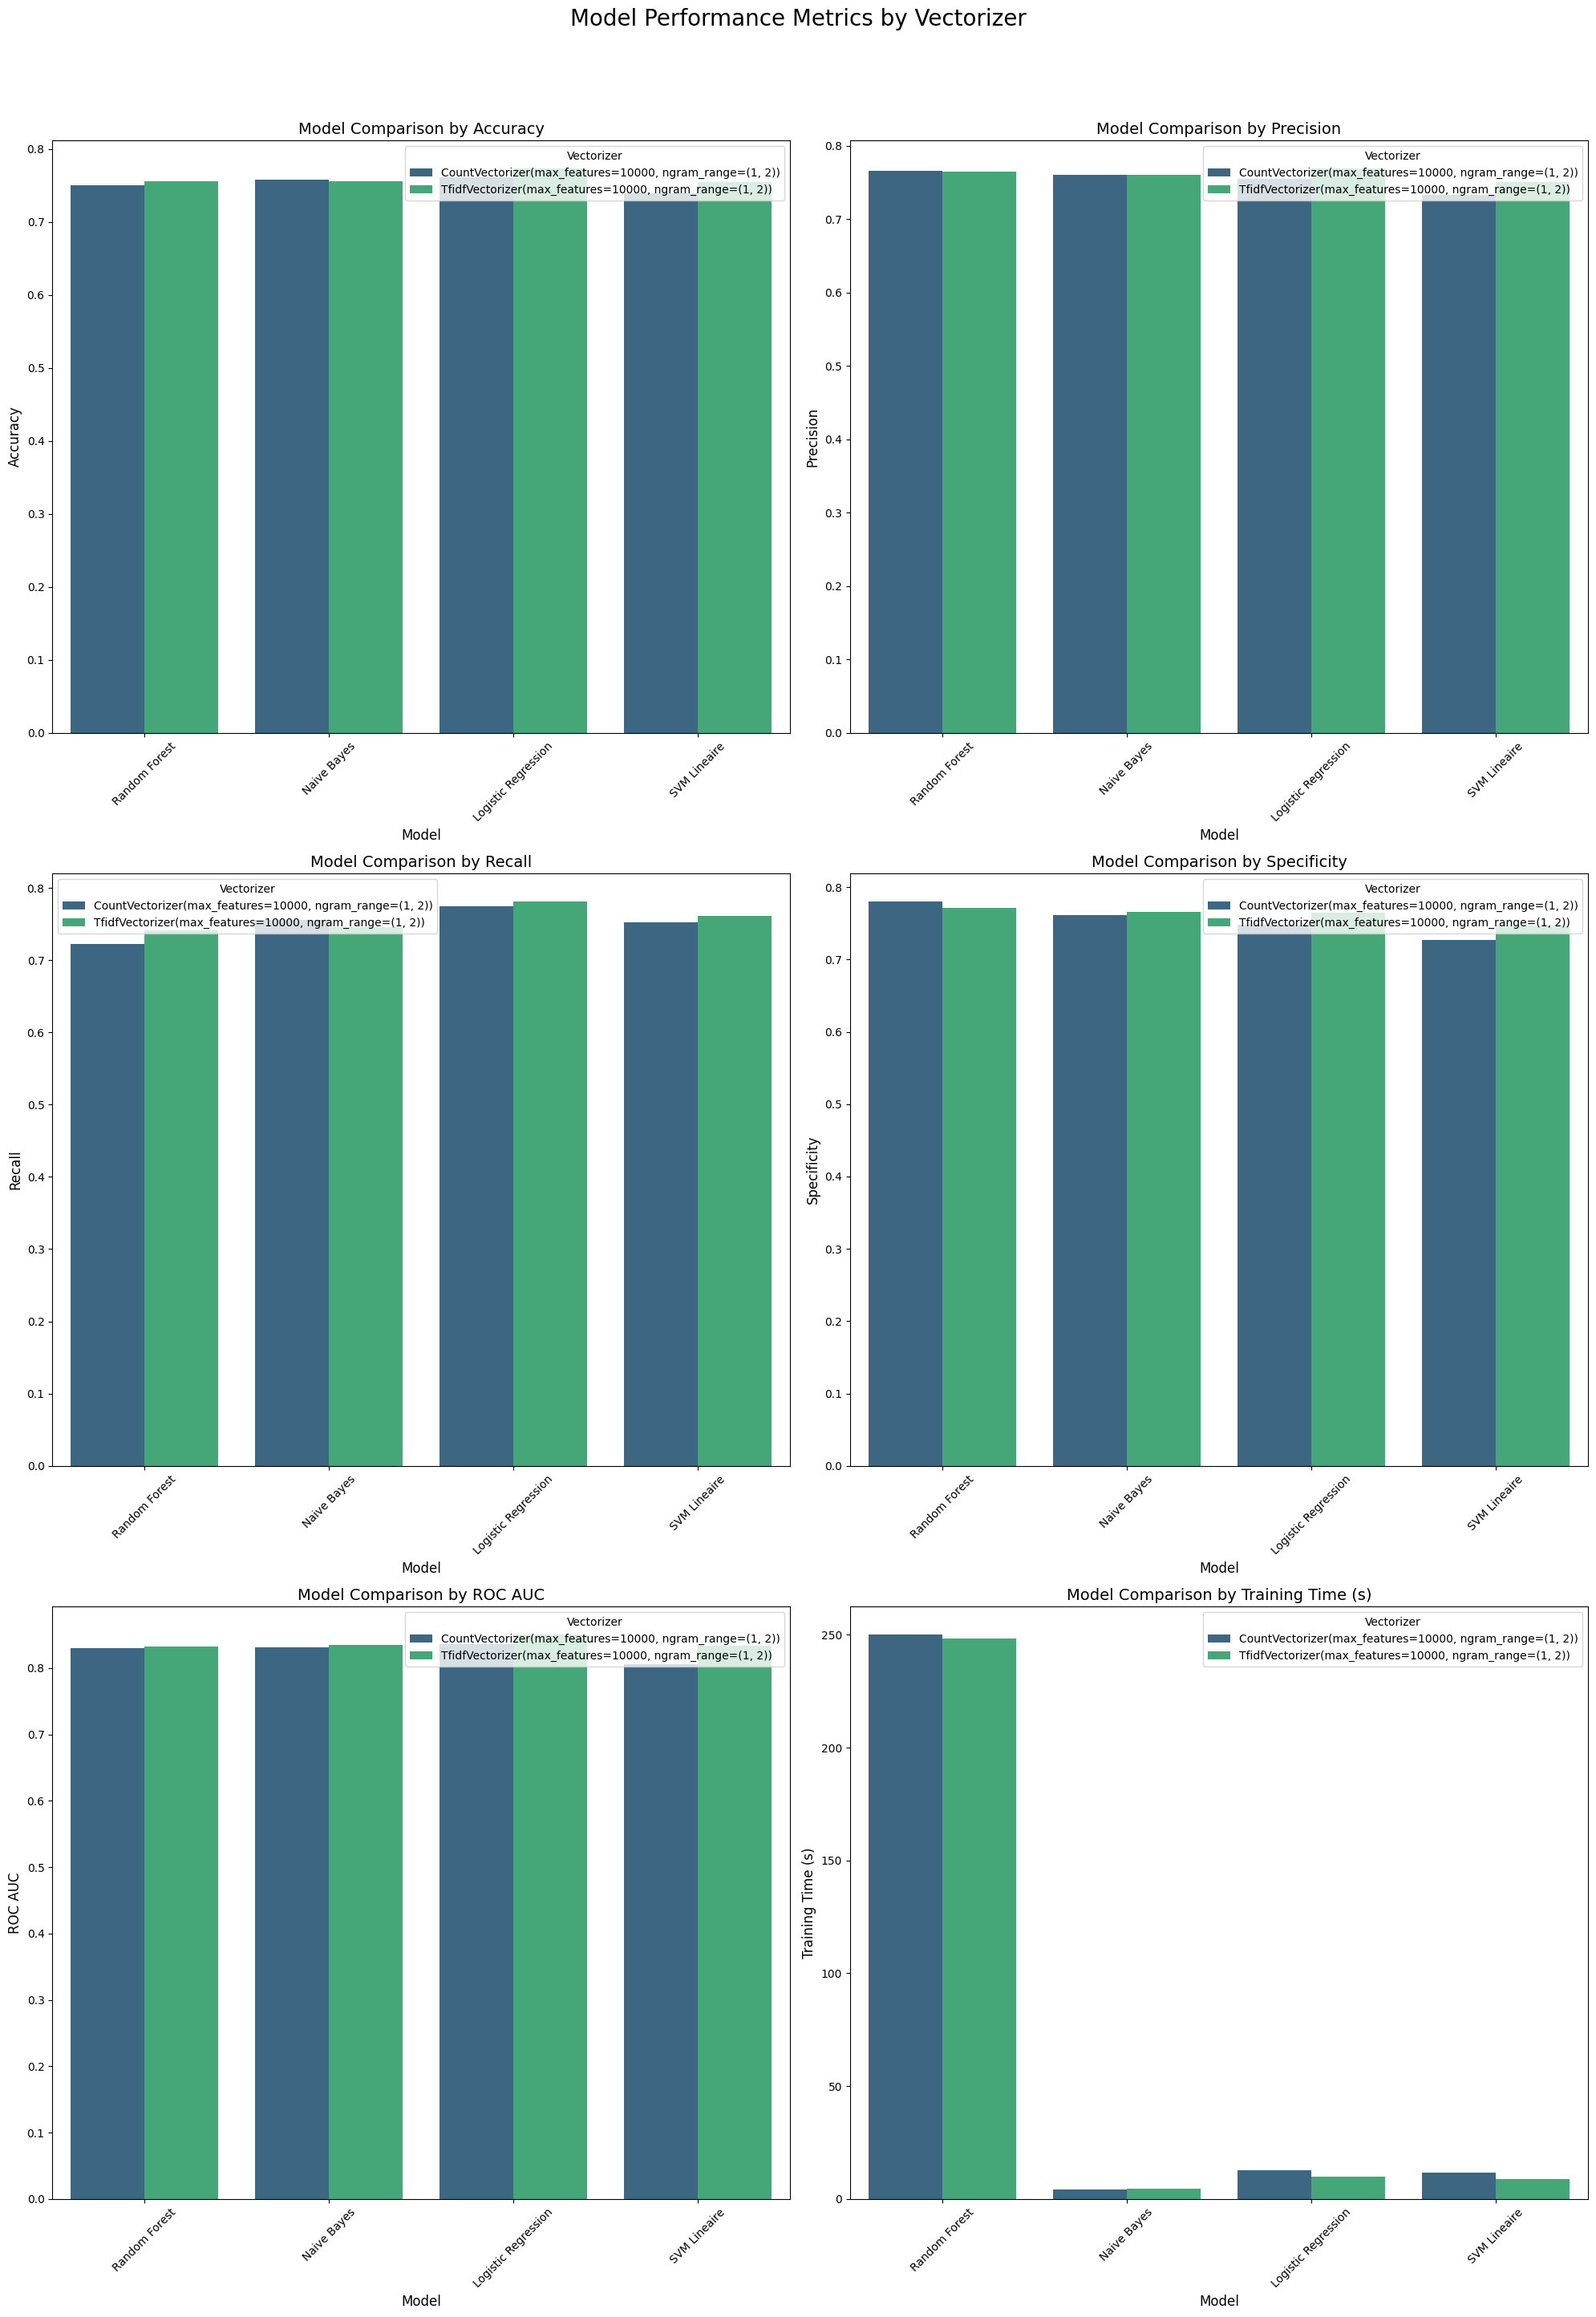

In [61]:
# Convert metric columns back to numeric for plotting
metric_cols = ["Accuracy", "Precision", "Recall", "Specificity", "ROC AUC", "Training Time (s)"]
for col in metric_cols:
    results_df[col] = pd.to_numeric(results_df[col], errors='coerce')

# Define the metrics to plot
metrics_to_plot = [
    "Accuracy", "Precision", "Recall", "Specificity", "ROC AUC", "Training Time (s)"
]

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 28))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    sns.barplot(data=results_df, x='Model', y=metric, hue='Vectorization', ax=axes[i], palette='viridis')
    axes[i].set_title(f'Model Comparison by {metric}', fontsize=14)
    axes[i].set_xlabel('Model', fontsize=12)
    axes[i].set_ylabel(metric, fontsize=12)
    axes[i].tick_params(axis='x', rotation=45, labelsize=10)
    axes[i].legend(title='Vectorizer')

# Adjust layout to prevent overlap and add a main title
fig.suptitle('Model Performance Metrics by Vectorizer', fontsize=20, y=1.03)
plt.tight_layout()
plt.show()

In [ ]:
# Get best model by taking the first row of the results_df and checking that the training_time is lower than the median of the training_time column
filtered_results_df = results_df[results_df['Training Time (s)'] < results_df['Training Time (s)'].median()]
best_model_row = filtered_results_df.iloc[0]
best_model_name = best_model_row['Model'].replace(" ", "_")
first_best_vectorizer = best_model_row['Strategy']
print(f"Best model identified: {best_model_name} with {first_best_vectorizer}")

Best model identified: Naive Bayes with BoW_stem_adv


In [69]:
# Get the best model details that is not the same as the best model
filtered_results_df = filtered_results_df[filtered_results_df['Model'].replace(" ", "_") != best_model_name]
second_best_model_row = filtered_results_df.iloc[0]
second_best_model_name = second_best_model_row['Model'].replace(" ", "_")
second_best_vectorizer = second_best_model_row['Strategy']


print(f"Best model: {best_model_name} with {first_best_vectorizer}")
print(f"Best second model: {second_best_model_name} with {second_best_vectorizer}")

# Get hypeparameters for the best model and the svm model from the param_grids
best_model_params = param_grids.get(best_model_name, {})
best_second_model_params = param_grids.get(second_best_model_name, {})

# GridSearchCV for hyperparameter tuning
def perform_grid_search(model, param_grid, X_train, y_train, cv=5, scoring='accuracy'):
    """
    Performs GridSearchCV to find the best hyperparameters for a given model.

    Args:
        model: The machine learning model to tune.
        param_grid (dict): The hyperparameter grid to search.
        X_train: The training features.
        y_train: The training labels.
        cv (int): Number of cross-validation folds.
        scoring (str): Scoring metric for evaluation.

    Returns:
        best_model: The model with the best found hyperparameters.
        best_params: The best hyperparameters found.
        best_score: The best cross-validation score achieved.
    """
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               scoring=scoring,
                               cv=cv,
                               n_jobs=-1,
                               verbose=1)

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    return best_model, best_params, best_score


# Get the vectorizer and data for the best model
vectorizer, X_train_best, X_test_best, y_train_best, y_test_best = vectorizers[first_best_vectorizer]
vectorizer_sec, X_train_sec, X_test_sec, y_train_sec, y_test_sec = vectorizers[second_best_vectorizer]
# Perform GridSearchCV for the best model
if best_model_params:
    print(f"\nPerforming GridSearchCV for the best model: {best_model_name} with {vectorizer}")
    base_model_best = base_models[best_model_name]
    best_model, best_params, best_score = perform_grid_search(base_model_best, best_model_params, X_train_best, y_train_best)

    print(f"Best hyperparameters for {best_model_name}: {best_params}")
    print(f"Best cross-validation score for {best_model_name}: {best_score:.4f}")

    # Evaluate the tuned best model
    acc, prec, rec, specificity, roc_auc, fig_cm, fig_roc, y_pred = evaluate_model(
        best_model, X_test_best, y_test_best, f"Tuned_{best_model_name}", vectorizer
    )

    # Log the tuned best model to MLflow
    with mlflow.start_run(run_name=f"Tuned_Model_{best_model_name}_{vectorizer}"):
        # Log parameters
        mlflow.log_param("model_type", best_model_name)
        mlflow.log_param("vectorizer_type", vectorizer)
        for param, value in best_params.items():
            mlflow.log_param(param, value)
        mlflow.log_param("dataset_size", X_train_shape[0] + X_test_shape[0])
        mlflow.log_param("train_size", X_train_shape[0])
        mlflow.log_param("test_size", X_test_shape[0])
        mlflow.log_param("max_features", 10000)
        mlflow.log_param("ngram_range", "(1, 2)")

        # Log metrics
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("specificity", specificity)
        mlflow.log_metric("roc_auc", roc_auc)

        # Log confusion matrix and ROC curve figures
        mlflow.log_figure(fig_cm, "confusion_matrix.png")
        mlflow.log_figure(fig_roc, "roc_curve.png")
        plt.close(fig_cm)
        plt.close(fig_roc)

        # Log the model
        # Prepare data for MLflow signature
        X_for_signature = prepare_for_mlflow(X_train_best)
        y_for_signature = y_pred if not isinstance(y_pred, pd.Series) else y_pred.values

        signature = infer_signature(X_for_signature, y_for_signature)
        mlflow.sklearn.log_model(best_model, "model", signature=signature)

        # Save the model artifacts into a specific directory
        os.makedirs("./content/tuned-model", exist_ok=True)

        # Save and log the vectorizer
        vectorizer_path = f"./content/tuned-model/vectorizer_{vectorizer}.pkl"
        with open(vectorizer_path, "wb") as f:
            pickle.dump(vectorizer, f)
        mlflow.log_artifact(vectorizer_path)

# Perform GridSearchCV for the best SVM model
if best_second_model_params:
    print(f"\nPerforming GridSearchCV for the best SVM model: {second_best_model_name} with {second_best_vectorizer}")
    base_model_svm = base_models[second_best_model_name]
    best_sec_model, best_sec_params, best_sec_score = perform_grid_search(base_model_svm, best_second_model_params, X_train_sec, y_train_sec)

    print(f"Best hyperparameters for {second_best_model_name}: {best_sec_params}")
    print(f"Best cross-validation score for {second_best_model_name}: {best_sec_score:.4f}")

    # Evaluate the tuned best SVM model
    acc, prec, rec, specificity, roc_auc, fig_cm, fig_roc, y_pred = evaluate_model(
        best_sec_model, X_test_sec, y_test_sec, f"Tuned_{second_best_model_name}", second_best_vectorizer
    )

    # Log the tuned best SVM model to MLflow
    with mlflow.start_run(run_name=f"Tuned_Model_{second_best_model_name}_{second_best_vectorizer}"):
        # Log parameters
        mlflow.log_param("model_type", second_best_model_name)
        mlflow.log_param("vectorizer_type", second_best_vectorizer)
        for param, value in best_sec_params.items():
            mlflow.log_param(param, value)
        mlflow.log_param("dataset_size", X_train_shape[0] + X_test_shape[0])
        mlflow.log_param("train_size", X_train_shape[0])
        mlflow.log_param("test_size", X_test_shape[0])
        mlflow.log_param("max_features", 10000)
        mlflow.log_param("ngram_range", "(1, 2)")

        # Log metrics
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("specificity", specificity)
        mlflow.log_metric("roc_auc", roc_auc)

        # Log confusion matrix and ROC curve figures
        mlflow.log_figure(fig_cm, "confusion_matrix.png")
        mlflow.log_figure(fig_roc, "roc_curve.png")
        plt.close(fig_cm)
        plt.close(fig_roc)

        # Log the model
        # Prepare data for MLflow signature
        X_for_signature = prepare_for_mlflow(X_train_sec)
        y_for_signature = y_pred if not isinstance(y_pred, pd.Series) else y_pred.values

        signature = infer_signature(X_for_signature, y_for_signature)
        mlflow.sklearn.log_model(best_sec_model, "model", signature=signature)
        # Save the model artifacts into a specific directory
        os.makedirs("./content/tuned-model", exist_ok=True)
        # Save and log the vectorizer
        vectorizer_path = f"./content/tuned-model/vectorizer_{second_best_vectorizer}.pkl"
        with open(vectorizer_path, "wb") as f:
            pickle.dump(vectorizer_sec, f)
        mlflow.log_artifact(vectorizer_path)


2025/11/07 15:30:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ebc93f0bfd5e4259b4d18b6cdd176bb7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Best model: Naive Bayes with BoW_stem_adv
Best second model: Logistic_Regression with BoW_stem_adv

Performing GridSearchCV for the best SVM model: Logistic_Regression with BoW_stem_adv


2025/11/07 15:30:55 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Fitting 5 folds for each of 384 candidates, totalling 1920 fits


/Users/ikusawalaetitia/Documents/oc-projects/python/aiengineer/P7-Sentiments_analysis/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ikusawalaetitia/Documents/oc-projects/python/aiengineer/P7-Sentiments_analysis/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ikusawalaetitia/Documents/oc-projects/python/aiengineer/P7-Sentiments_analysis/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ikusawalaetitia/Documents/oc-projects/python/aiengineer/P7-Sentiments_analysis/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
 

🏃 View run popular-wasp-239 at: http://localhost:8081/#/experiments/936418666609461070/runs/ebc93f0bfd5e4259b4d18b6cdd176bb7
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070
Best hyperparameters for Logistic_Regression: {'C': 0.1, 'class_weight': None, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}
Best cross-validation score for Logistic_Regression: 0.7626

Results for Tuned_Logistic_Regression with BoW_stem_adv:
Accuracy: 0.7698
Precision: 0.7605
Recall: 0.7876
Specificity: 0.7520
ROC AUC: 0.8439

Confusion matrix:
[[3760 1240]
 [1062 3938]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.78      0.75      0.77      5000
           1       0.76      0.79      0.77      5000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



2025/11/07 18:19:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Tuned_Model_Logistic_Regression_BoW_stem_adv at: http://localhost:8081/#/experiments/936418666609461070/runs/e4b42c8604ae4628889d66bb1f6843bc
🧪 View experiment at: http://localhost:8081/#/experiments/936418666609461070


In [70]:
tuned_results_df = get_mlflow_results(experiment_name="P7-Sentiments_Analysis", run_name="Tuned_Model_", uri=tracking_uri)
display(tuned_results_df)

,Run Name,Run ID,Strategy,Model,Vectorization,Accuracy,Precision,Recall,Specificity,ROC AUC,Training Time (s),Run Start (UTC)
0,Tuned_Model_Naive_Bayes_BoW_stem_adv,394858843f284b55b5edb0e2561c3d87,BoW_stem_adv,Naive Bayes,BoW_stem_adv,0.7609,0.763163,0.7566,0.7652,0.833378,NaN,2025-11-07 14:11:05.267
1,Tuned_Model_Naive_Bayes_CountVectorizer(max_fe...,3af1a327d9d441e9a8955ac4d029da71,BoW_stem_adv,Naive Bayes,"CountVectorizer(max_features=10000, ngram_rang...",0.7609,0.763163,0.7566,0.7652,0.833378,NaN,2025-11-07 14:10:55.739
2,Tuned_Model_Logistic_Regression_BoW_stem_adv,e4b42c8604ae4628889d66bb1f6843bc,BoW_stem_adv,Logistic Regression,BoW_stem_adv,0.7698,0.760525,0.7876,0.7520,0.843884,NaN,2025-11-07 17:19:02.114


,Model,Vectorization,Default_Accuracy,Tuned_Accuracy,Default_Specificity,Tuned_Specificity,Default_ROC_AUC,Tuned_ROC_AUC,Accuracy_Improvement,Specificity_Improvement,ROC_AUC_Improvement
0,Naive Bayes,"TfidfVectorizer(max_features=10000, ngram_rang...",0.7554,0.7609,0.7656,0.7652,0.834528,0.833378,0.0055,-0.0004,-0.001149
1,Logistic Regression,"TfidfVectorizer(max_features=10000, ngram_rang...",0.7727,0.7698,0.7648,0.7520,0.849955,0.843884,-0.0029,-0.0128,-0.006071


<Figure size 1500x800 with 0 Axes>

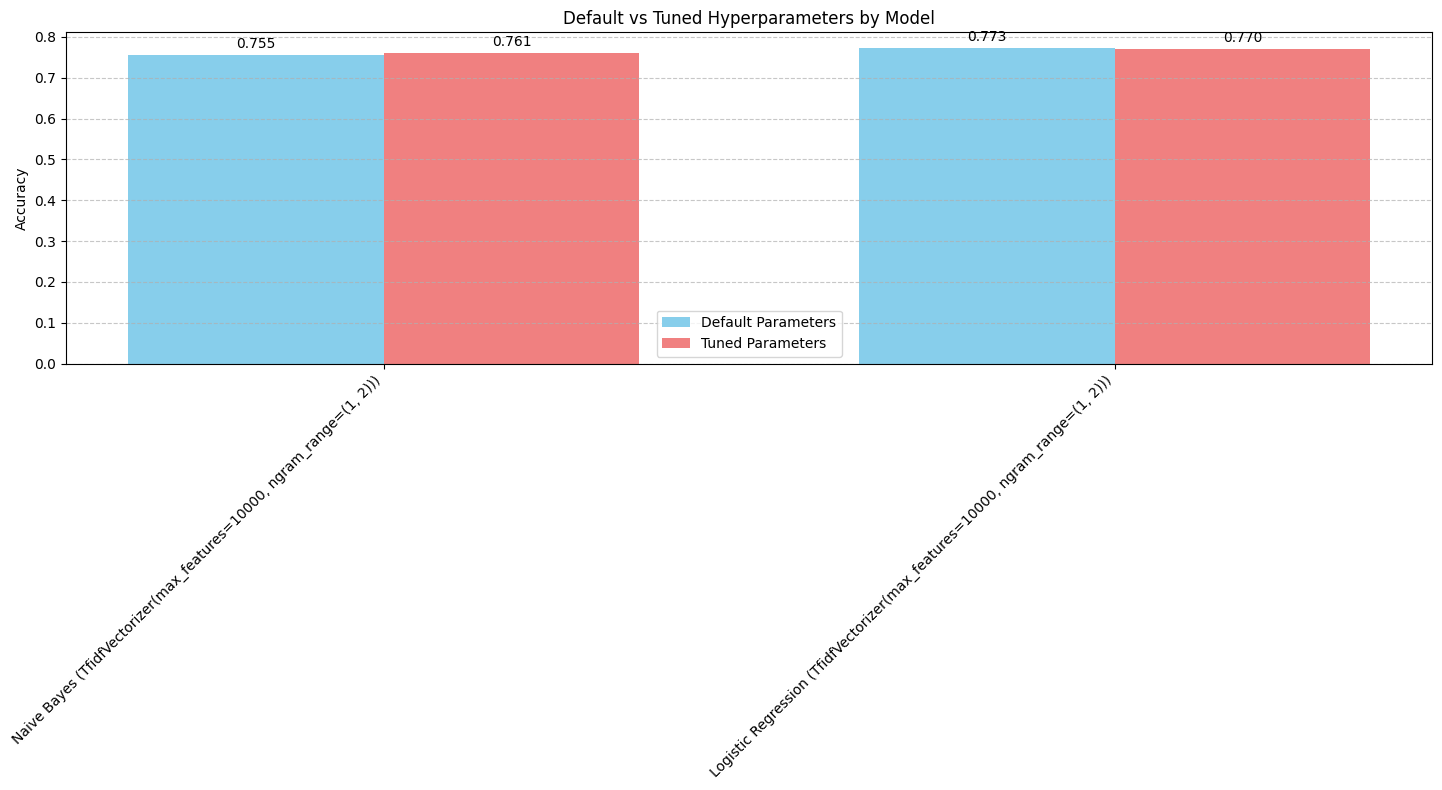

In [74]:
# Compare performance of models with default parameters vs tuned hyperparameters
# This helps identify which models benefit most from hyperparameter tuning

# First, wait for tuned model results to be available
if 'tuned_results_df' not in locals() or tuned_results_df.empty:
    print("No tuned model results available yet. Run the hyperparameter tuning cells first.")
else:
    # Merge basic and tuned results
    comparison_df = pd.DataFrame()

    for model in tuned_results_df['Model'].unique():
        for vec in tuned_results_df['Strategy'].unique():
            # Get the basic model result
            basic = results_df[(results_df['Model'] == model) & (results_df['Strategy'] == vec)]

            # Try to find the corresponding tuned model
            tuned = tuned_results_df[(tuned_results_df['Model'] == model) & (tuned_results_df['Strategy'] == vec)]

            if not basic.empty:
                row = {
                    'Model': model,
                    'Vectorization': basic['Vectorization'].values[0] if not basic.empty else None,
                    'Default_Accuracy': basic['Accuracy'].values[0] if not basic.empty else None,
                    'Tuned_Accuracy': tuned['Accuracy'].values[0] if not tuned.empty else None,
                    'Default_Specificity': basic['Specificity'].values[0] if not basic.empty else None,
                    'Tuned_Specificity': tuned['Specificity'].values[0] if not tuned.empty else None,
                    'Default_ROC_AUC': basic['ROC AUC'].values[0] if not basic.empty else None,
                    'Tuned_ROC_AUC': tuned['ROC AUC'].values[0] if not tuned.empty else None,
                }

                # Calculate improvement from tuning
                if not tuned.empty:
                    row['Accuracy_Improvement'] = row['Tuned_Accuracy'] - row['Default_Accuracy']
                    row['Specificity_Improvement'] = row['Tuned_Specificity'] - row['Default_Specificity']
                    row['ROC_AUC_Improvement'] = row['Tuned_ROC_AUC'] - row['Default_ROC_AUC']

                comparison_df = pd.concat([comparison_df, pd.DataFrame([row])], ignore_index=True)

    if not comparison_df.empty:
        # Sort by accuracy improvement
        comparison_df = comparison_df.sort_values(by='Accuracy_Improvement', ascending=False)

        # Display the comparison
        display(comparison_df)

        # Plot the improvements
        plt.figure(figsize=(15, 8))

        # Create a grouped bar chart showing default vs tuned performance
        models = comparison_df['Model'] + " (" + comparison_df['Vectorization'] + ")"
        x = np.arange(len(models))
        width = 0.35

        fig, ax = plt.subplots(figsize=(15, 8))
        rects1 = ax.bar(x - width/2, comparison_df['Default_Accuracy'], width, label='Default Parameters', color='skyblue')
        rects2 = ax.bar(x + width/2, comparison_df['Tuned_Accuracy'], width, label='Tuned Parameters', color='lightcoral')

        ax.set_ylabel('Accuracy')
        ax.set_title('Default vs Tuned Hyperparameters by Model')
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Add value labels on the bars
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.3f}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

        autolabel(rects1)
        autolabel(rects2)

        plt.tight_layout()
        plt.show()
    else:
        print("No comparison data available.")

In [78]:
best_params

{'alpha': 5.0, 'fit_prior': True}

# Save best model

In [76]:
def load_and_save_model_from_mlflow(experiment_name: str, save_dir: str = "./content/basic-model/best", uri: str = None) -> tuple:
    """
    Loads the best model and its vectorizer from MLflow and saves them locally.

    Args:
        experiment_name (str): The name of the MLflow experiment.
        model_name (str): The name of the model to load.
        vectorizer_name (str): The name of the vectorizer to load.
        save_dir (str): The directory to save the model and vectorizer.
        uri (str): Optional; the URI of the MLflow tracking server. If None, uses the default tracking URI.

    Returns:
        Tuple: The loaded model and vectorizer.
    """
    # Connect to the MLflow tracking server
    if uri:
        mlflow.set_tracking_uri(uri)

    # Create mlflow client
    client = MlflowClient()

    # Get the experiment ID by name
    try:
        experiment = client.get_experiment_by_name(experiment_name)
        if not experiment:
            raise ValueError(f"Experiment '{experiment_name}' not found.")
        experiment_id = experiment.experiment_id
    except Exception as e:
        print(f"Error retrieving experiment '{experiment_name}': {experiment}")
        return

    # Search for the best model run based on F1 score
    model_name = results_df.iloc[0]['Model']
    vectorizer_name = results_df.iloc[0]['Vectorization']
    basic_model_runs = client.search_runs(experiment_ids=[experiment_id],
                            filter_string=f"tags.mlflow.runName LIKE '%Basic_Model_{model_name.replace(' ', '_')}_{vectorizer_name}%'",
                            order_by=["metrics.specificity DESC"],
                            max_results=1)

    tuned_model_runs = client.search_runs(experiment_ids=[experiment_id],
                            filter_string=f"tags.mlflow.runName LIKE '%Tuned_Model_{model_name.replace(' ', '_')}_{vectorizer_name}%'",
                            order_by=["metrics.specificity DESC"],
                            max_results=1)

    runs = tuned_model_runs + basic_model_runs
    if not runs:
        print(f"No runs found for model '{model_name}' with vectorizer '{vectorizer_name}'.")
        return

    best_run = max(runs, key=lambda run: run.data.metrics.get("specificity", 0))
    run_id = best_run.info.run_id

    # Load the model from MLflow
    model_uri = f"runs:/{run_id}/model"
    model = mlflow.sklearn.load_model(model_uri)

    # Load the vectorizer artifact
    vectorizer_artifact_path = f"vectorizer_{vectorizer_name}.pkl"
    local_vectorizer_path = client.download_artifacts(run_id, vectorizer_artifact_path, dst_path=".")
    with open(local_vectorizer_path, "rb") as f:
        vectorizer = pickle.load(f)

    # Save the model and vectorizer locally
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, "best_model.pkl")
    vectorizer_path = os.path.join(save_dir, f"vectorizer_{vectorizer_name}.pkl")
    with open(model_path, "wb") as f:
        pickle.dump(model, f)
    with open(vectorizer_path, "wb") as f:
        pickle.dump(vectorizer, f)
    print(f"Model and vectorizer saved to '{save_dir}'.")

    return model, vectorizer

In [77]:
# Load and save the best model and vectorizer
best_model, best_vectorizer = load_and_save_model_from_mlflow(
    experiment_name="P7-Sentiments_Analysis",
    save_dir="./content/basic_model/best",
    uri=tracking_uri
)

No runs found for model 'Random Forest' with vectorizer 'CountVectorizer(max_features=10000, ngram_range=(1, 2))'.


TypeError: cannot unpack non-iterable NoneType object

# Test best model

In [ ]:
# Let's analyze specific examples of how stemming and lemmatization affect sentiment words

# Sample text with various sentiment words and their variations
sentiment_examples = [
    "I love this product. It's lovely and I'm loving it!",
    "This is the worst, I hated it, and I will always hate it.",
    "Good, better, best - this was the greatest experience.",
    "Bad, worse, worst - this was the most terrible experience.",
    "The movie was amazing, and I was amazed by the effects.",
    "I am very happy with my purchase, it brings happiness.",
    "I am sad and feeling sadness about the situation."
]

print("Comparing stemming and lemmatization on sentiment examples:")
print("=" * 70)

for text in sentiment_examples:
    lemmatized = process_text(text, lemmatize=True)
    stemmed = process_text(text, stemming=True)

    print(f"Original: {text}")
    print(f"Lemmatized: {lemmatized}")
    print(f"Stemmed: {stemmed}")
    print("-" * 70)

# More detailed analysis of stemming vs lemmatization effects on sentiment classification
from sklearn.feature_extraction.text import CountVectorizer

# Create small vectorizers for demonstration
mini_bow_lem = CountVectorizer(max_features=100)
mini_bow_stem = CountVectorizer(max_features=100)

# Fit on a sample of the data
sample_texts_lem = sample_df['processed_text_lem'].sample(1000, random_state=42)
sample_texts_stem = sample_df['processed_text_stem'].sample(1000, random_state=42)

X_sample_lem = mini_bow_lem.fit_transform(sample_texts_lem)
X_sample_stem = mini_bow_stem.fit_transform(sample_texts_stem)

# Get the vocabulary (feature names)
lem_features = mini_bow_lem.get_feature_names_out()
stem_features = mini_bow_stem.get_feature_names_out()

print("\nVocabulary comparison (top features):")
print(f"Lemmatization features (first 20): {lem_features[:20]}")
print(f"Stemming features (first 20): {stem_features[:20]}")

# Count how many features contain common sentiment roots
sentiment_roots = ['good', 'bad', 'love', 'hate', 'happ', 'sad']

print("\nSentiment root occurrence in features:")
for root in sentiment_roots:
    lem_count = sum(1 for feature in lem_features if root in feature)
    stem_count = sum(1 for feature in stem_features if root in feature)
    print(f"Root '{root}': {lem_count} lemmatized features, {stem_count} stemmed features")

In [ ]:
# Automatically retrieve the best vectorizer from the results DataFrame
best_vectorizer_name = tuned_results_df.iloc[0]['Vectorization']  # Get the best vectorizer name
first_best_vectorizer, X_train_vec, X_test_vec, y_train_vec, y_test_vec = vectorizers[best_vectorizer_name]

# Display the chosen vectorizer and its train-test set shapes
print(f"Chosen vectorizer: {best_vectorizer_name}")
print(f"X_train_vec shape: {X_train_vec.shape}")
print(f"X_test_vec shape: {X_test_vec.shape}")
print(f"y_train_vec shape: {y_train_vec.shape}")
print(f"y_test_vec shape: {y_test_vec.shape}")

Chosen vectorizer: TF-IDF_stem
X_train_vec shape: (40000, 10000)
X_test_vec shape: (10000, 10000)
y_train_vec shape: (40000,)
y_test_vec shape: (10000,)


In [ ]:
def predict_sentiment(text: str, model=best_model, vectorizer=best_vectorizer) -> pd.DataFrame:
    """
    Predicts the sentiment of a given text using a trained model and vectorizer.

    Args:
        text (str): The input text to analyze.
        model: The trained classification model.
        vectorizer: The fitted text vectorizer.

    Returns:
        pd.DataFrame: A DataFrame with the original text, predicted sentiment, and confidence score.
    """
    # Determine if stemming or lemmatization should be used based on the best vectorizer name
    use_stemming = "stem" in vectorizer
    use_lemmatization = "lem" in vectorizer

    # Preprocess the input text
    processed_text = process_text(text, lemmatize=use_lemmatization, stemming=use_stemming)

    # Vectorize the processed text
    vectorized_text = vectorizer.transform([processed_text])

    # Predict the sentiment
    prediction = model.predict(vectorized_text)[0]
    sentiment = "Positive" if prediction == 1 else "Negative"

    # Get confidence score
    confidence = None
    if hasattr(model, 'predict_proba'):
        # Get the probability of the predicted class
        probabilities = model.predict_proba(vectorized_text)[0]
        confidence = probabilities[prediction]
    elif hasattr(model, 'decision_function'):
        # Get the distance from the hyperplane as a confidence score
        score = model.decision_function(vectorized_text)[0]
        # For binary classification, negative score is class 0, positive is class 1
        confidence = abs(score)

    # Create a DataFrame with the results
    return {
        'Original Text': [text],
        'Predicted Sentiment': [sentiment],
        'Confidence': [confidence]
    }

In [47]:
# Create a list of customer reviews for a fictional travel company "airParadis"
customer_reviews = [
    # Positive reviews
    "My trip with airParadis was absolutely fantastic! The service was impeccable and the destination was a dream. Highly recommend!",
    "What an amazing experience! From booking to landing, everything was smooth and professional. airParadis made our vacation unforgettable.",
    "I had the best time of my life. The crew was so friendly and helpful. Can't wait to book my next trip with airParadis!",
    # Negative reviews
    "A complete disaster. My flight was delayed by hours with no explanation. I missed my connecting flight and the customer service was useless.",
    "I would not recommend airParadis to anyone. The plane was dirty, the staff was rude, and my luggage was lost. A terrible experience from start to finish.",
    "Worst travel company ever. They cancelled my flight last minute and offered no compensation. I had to scramble to find another flight and it ruined my vacation.",
    # Neutral reviews
    "The flight was on time and the booking process was straightforward. It was an average experience, nothing special to report.",
    "airParadis got me from point A to point B. The flight was okay, but the food options were limited.",
    "The trip was as expected. The plane departed and arrived on schedule. The service was standard."
]


In [50]:
reviews_predictions = []
for review in customer_reviews:
    prediction = predict_sentiment(review)
    reviews_predictions.append(prediction)

reviews_df = pd.concat([pd.DataFrame(pred) for pred in reviews_predictions], ignore_index=True)
display(reviews_df)

,Original Text,Predicted Sentiment,Confidence
0,My trip with airParadis was absolutely fantast...,Positive,0.609689
1,What an amazing experience! From booking to la...,Positive,0.873382
2,I had the best time of my life. The crew was s...,Positive,0.852304
3,A complete disaster. My flight was delayed by ...,Negative,0.919536
4,I would not recommend airParadis to anyone. Th...,Negative,0.826092
5,Worst travel company ever. They cancelled my f...,Negative,0.944823
6,The flight was on time and the booking process...,Positive,0.518334
7,airParadis got me from point A to point B. The...,Negative,0.525581
8,The trip was as expected. The plane departed a...,Positive,0.500588


In [ ]:
first_best_vectorizer

'TF-IDF_stem'

In [75]:
best_model_params

{}

# Conclusion

After testing 4 models, each model was tested on 2 preprocessing methods (lemmatization and stemming) and on two vectorization type (BoW and TF-IDF). As missing a negative comment is more important than missing a positive, we decided to evaluate a model by taking in consideration the specificity metric.

Our best model is a Logistic Regression using a stemming method as preprocessing and a TF-IDF type of vectorisation. Here are the key metrics =
- Accuracy : 77%
- Specificity : 77%
- ROC/AUC : 85%

We used the hyperparameters below:
{'C': 1.0, 10.0,
 'max_iter': 1000,
 'solver': 'liblinear'}